### Library Import

In [ ]:
import sys
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
sys.path.append(os.path.abspath('..'))

# from func.utils import evaluate_model


### Data Load

In [ ]:
# 파일 호출 (문제 생길시 적절히 data path 수정)
path: str = "../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

FileNotFoundError: [Errno 2] No such file or directory: '../data/train.csv'

In [ ]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:04<00:00, 21.75it/s]


In [ ]:
eda_df = df.loc[df["_type"] == "train"]
# 각 열에서 누락된 값의 수를 계산
missing_values = eda_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

,0
hourly_market-data_liquidations_ftx_all_symbol_short_liquidations,100.0
hourly_market-data_open-interest_kraken_open_interest,100.0
hourly_market-data_taker-buy-sell-stats_okex_taker_buy_volume,100.0
hourly_market-data_liquidations_ftx_all_symbol_long_liquidations_usd,100.0
hourly_market-data_open-interest_deribit_open_interest,100.0
...,...
hourly_market-data_open-interest_htx_global_btc_usdt_open_interest,0.0
hourly_market-data_open-interest_htx_global_btc_usd_open_interest,0.0
hourly_market-data_open-interest_binance_all_symbol_open_interest,0.0
hourly_market-data_open-interest_htx_global_all_symbol_open_interest,0.0


### Feature engineering

In [ ]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_network-data_addresses-count_addresses_count_active": "active_count",
    "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
}
df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape

(11552, 19)

In [ ]:
# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["buy_volume"] - df["sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    liquidation_usd_diffg=np.sign(df["long_liquidations_usd"] - df["short_liquidations_usd"]),
    volume_diffg=np.sign(df["buy_volume"] - df["sell_volume"]),
    buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + 1),
)
# category, continuous 열을 따로 할당해둠
category_cols: List[str] = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg"]
conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type"]] + [
    "buy_sell_volume_ratio",
    "liquidation_diff",
    "liquidation_usd_diff",
    "volume_diff",
]

In [ ]:
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[1,2,3,4,5]
)

In [ ]:
# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)


In [ ]:
for a in df.columns:
    print(a)

ID
target
_type
coinbase_premium_gap
coinbase_premium_index
funding_rates
long_liquidations
long_liquidations_usd
short_liquidations
short_liquidations_usd
open_interest
buy_ratio
buy_sell_ratio
buy_volume
sell_ratio
sell_volume
active_count
receiver_count
sender_count
liquidation_diff
liquidation_usd_diff
volume_diff
liquidation_diffg
liquidation_usd_diffg
volume_diffg
buy_sell_volume_ratio
coinbase_premium_gap_1
coinbase_premium_gap_2
coinbase_premium_gap_3
coinbase_premium_gap_4
coinbase_premium_gap_5
coinbase_premium_index_1
coinbase_premium_index_2
coinbase_premium_index_3
coinbase_premium_index_4
coinbase_premium_index_5
funding_rates_1
funding_rates_2
funding_rates_3
funding_rates_4
funding_rates_5
long_liquidations_1
long_liquidations_2
long_liquidations_3
long_liquidations_4
long_liquidations_5
long_liquidations_usd_1
long_liquidations_usd_2
long_liquidations_usd_3
long_liquidations_usd_4
long_liquidations_usd_5
short_liquidations_1
short_liquidations_2
short_liquidations_3
sh

In [ ]:
df_eda = df.drop(columns=['ID', 'target', '_type'])

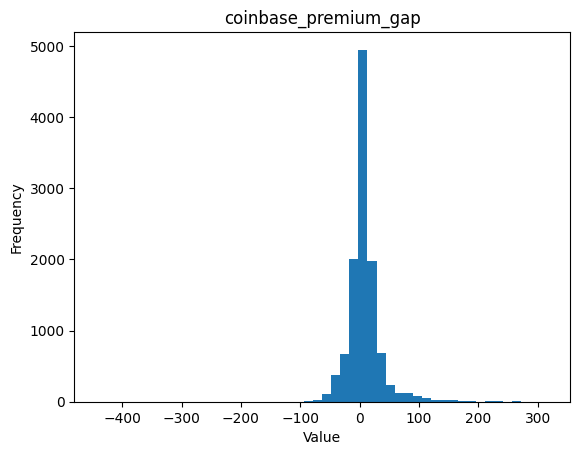

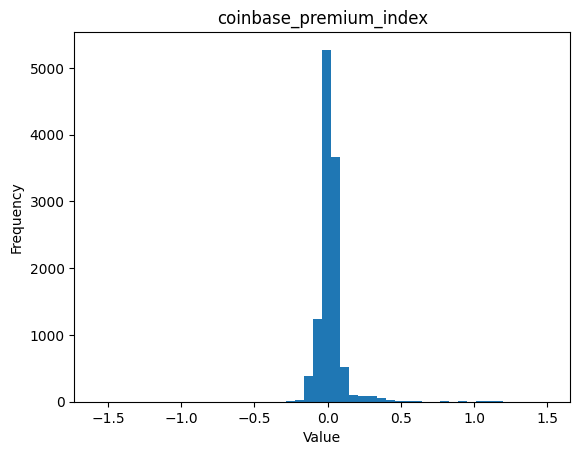

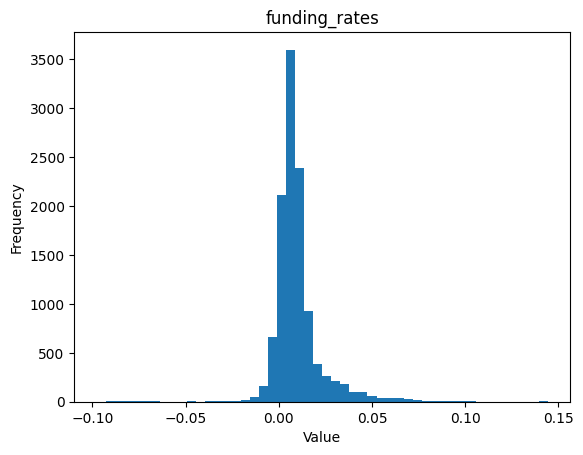

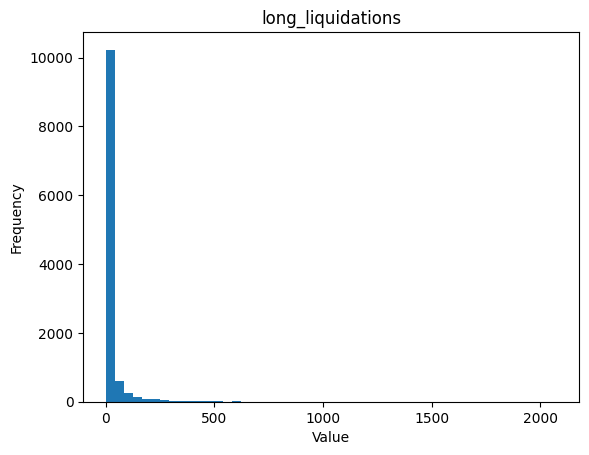

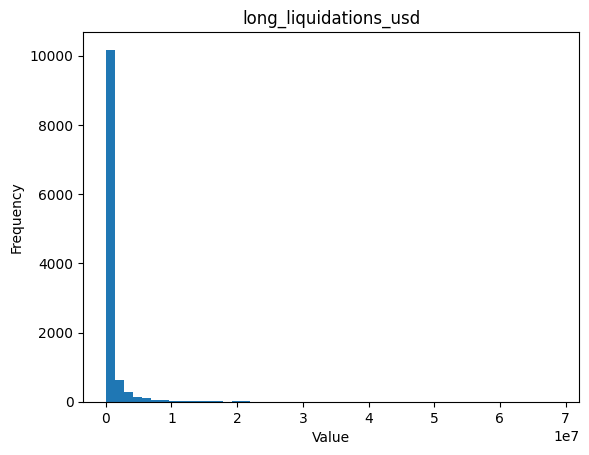

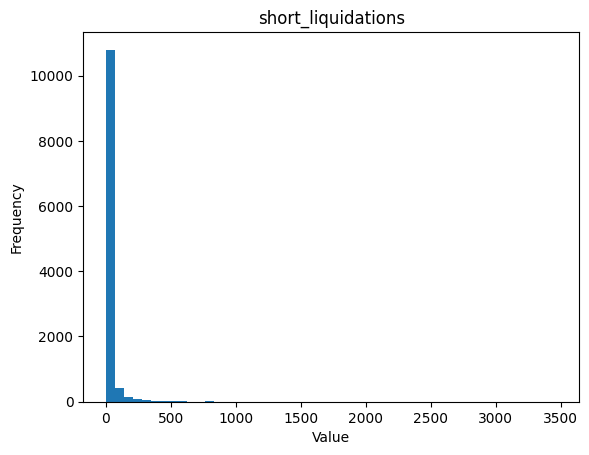

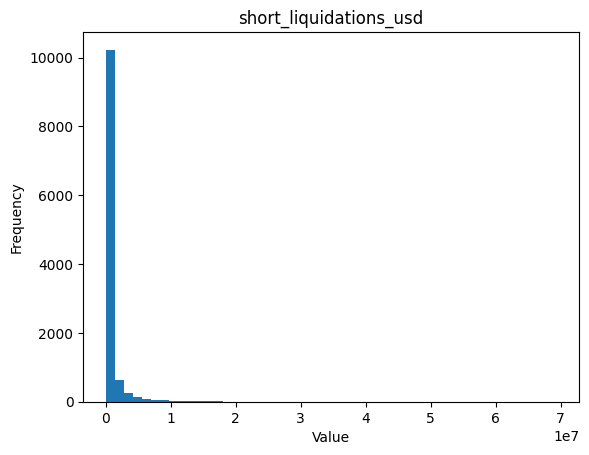

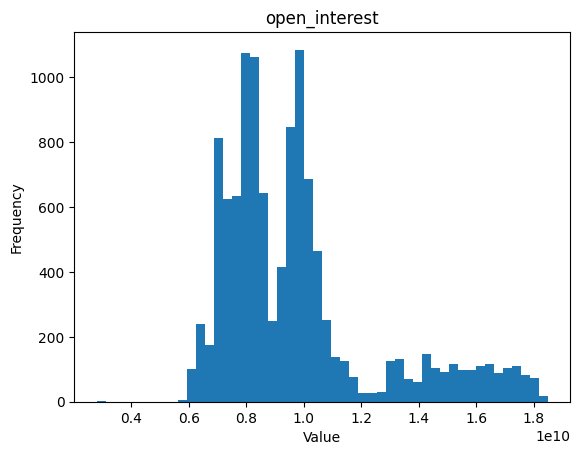

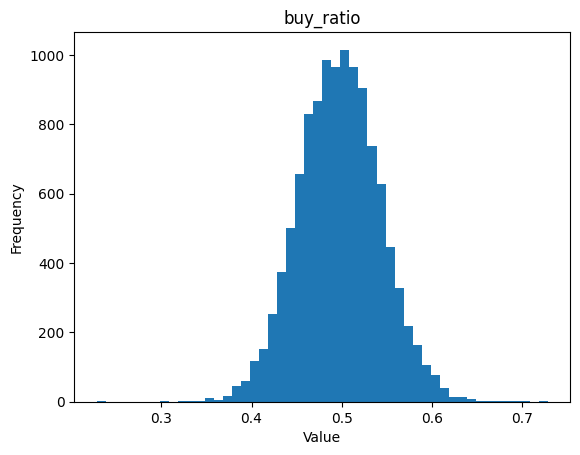

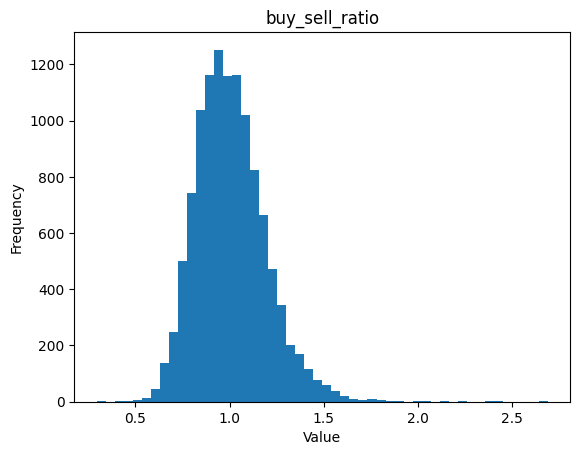

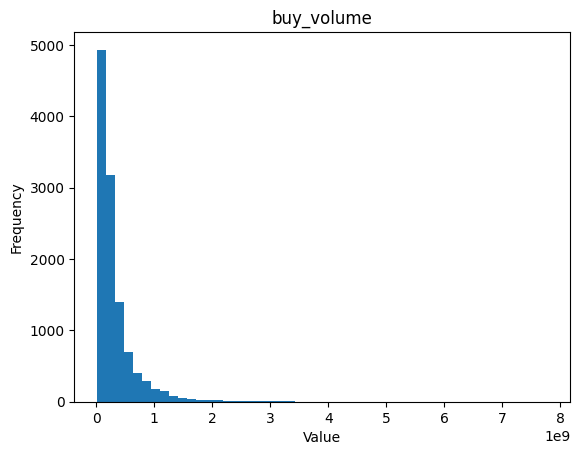

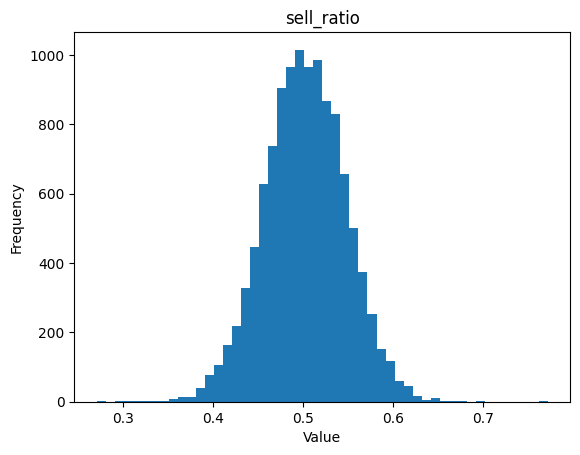

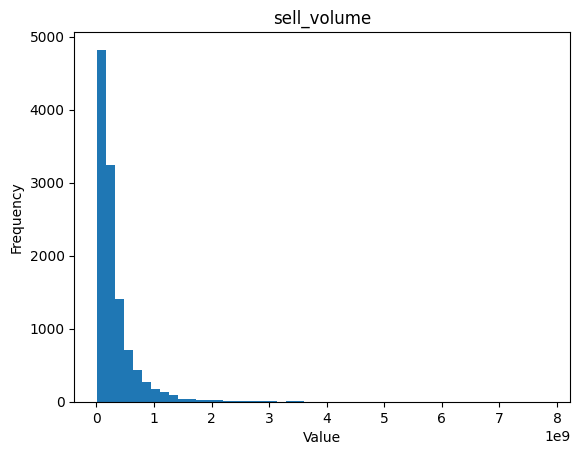

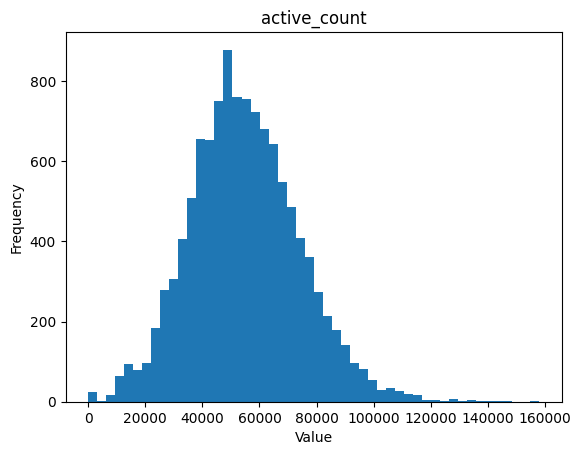

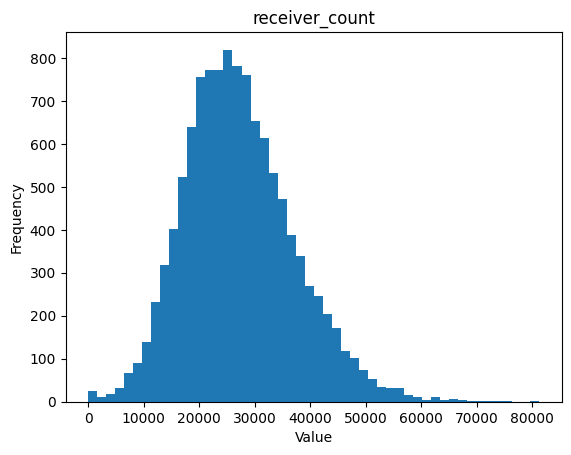

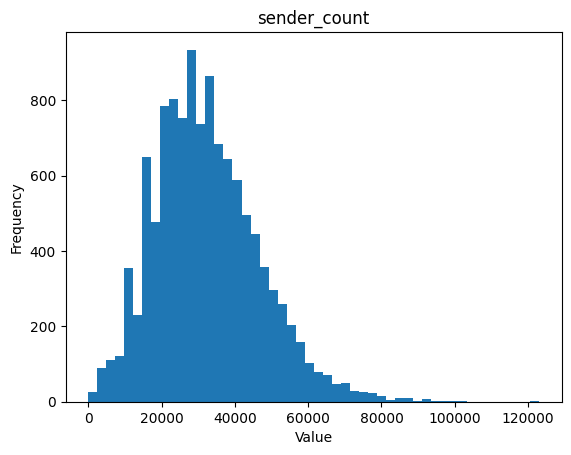

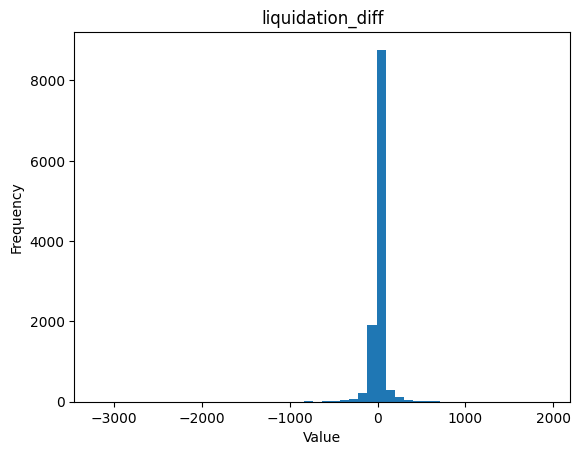

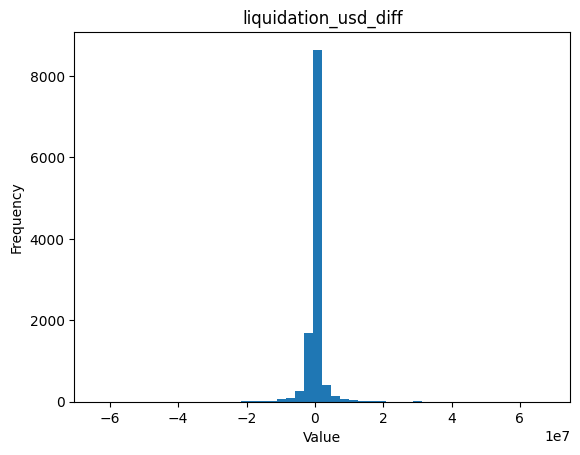

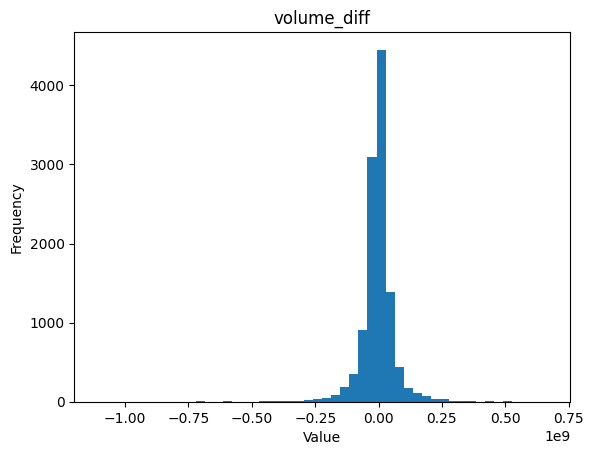

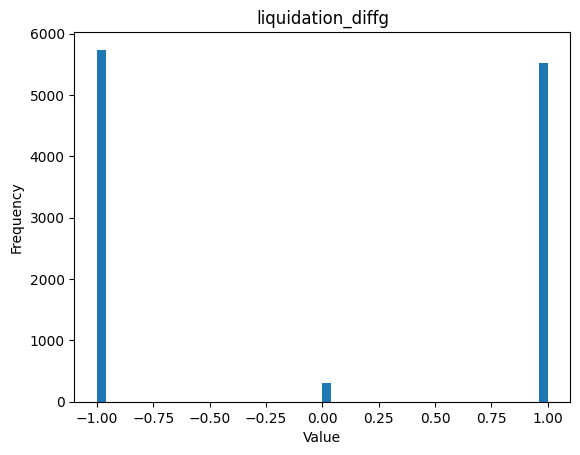

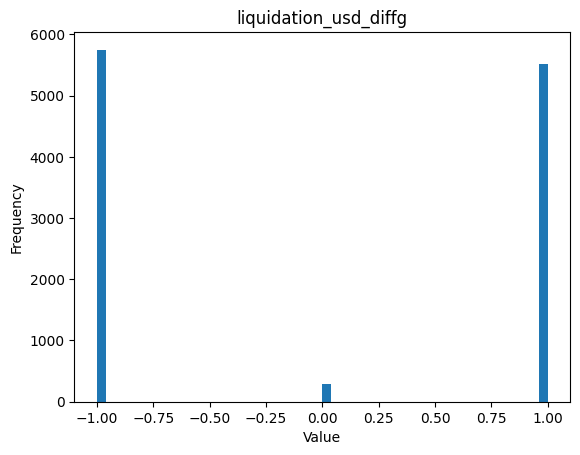

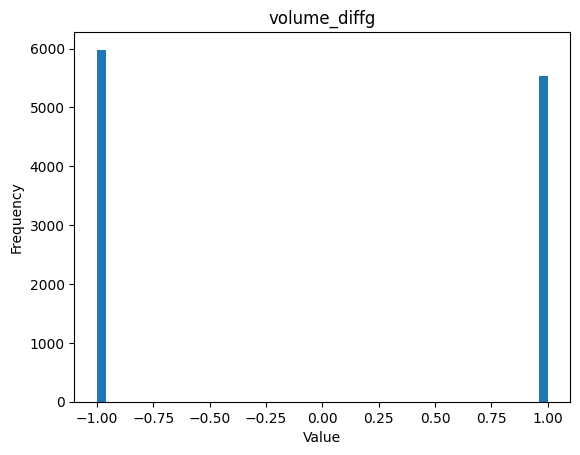

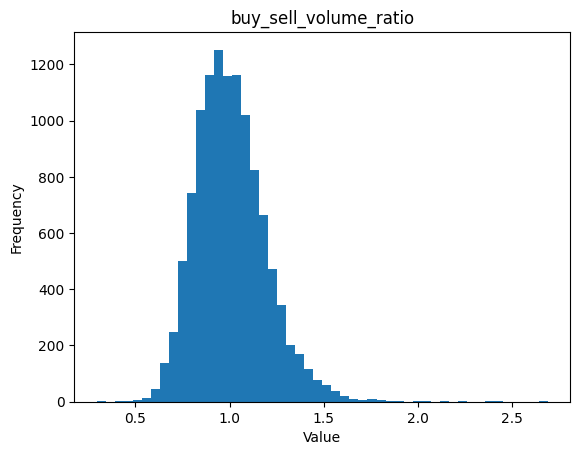

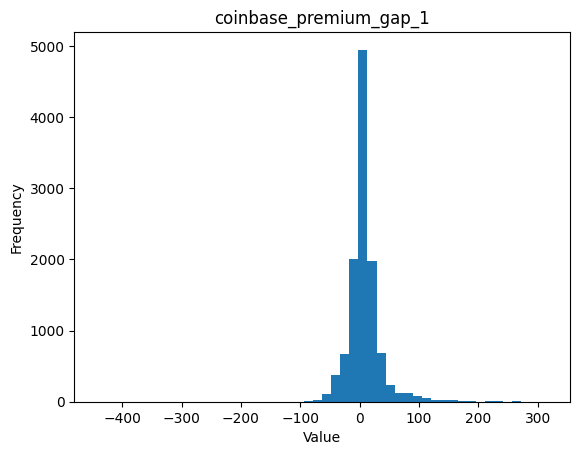

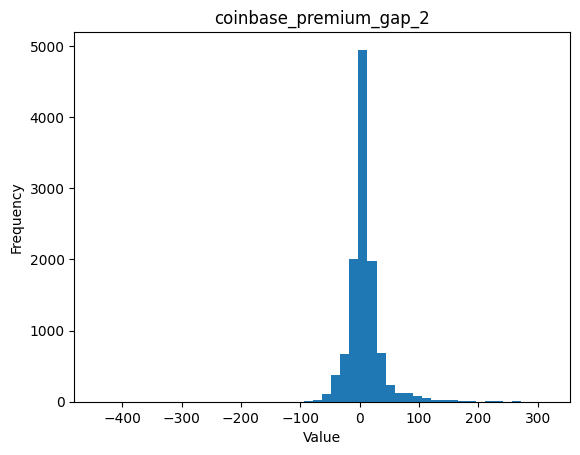

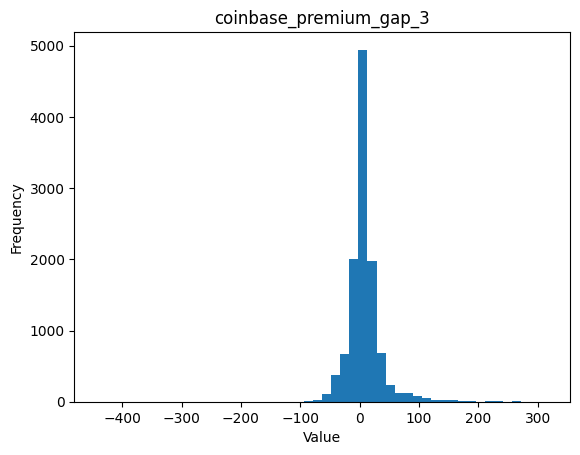

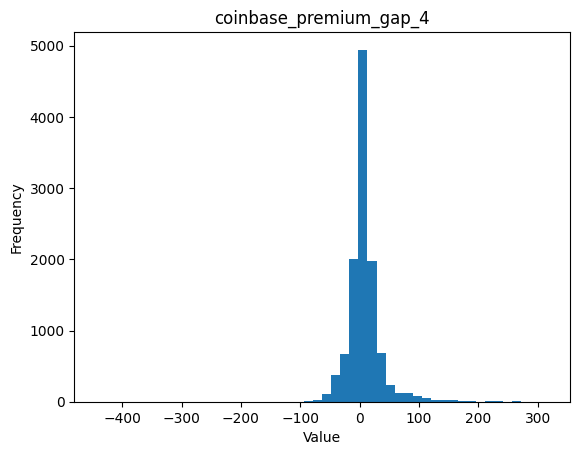

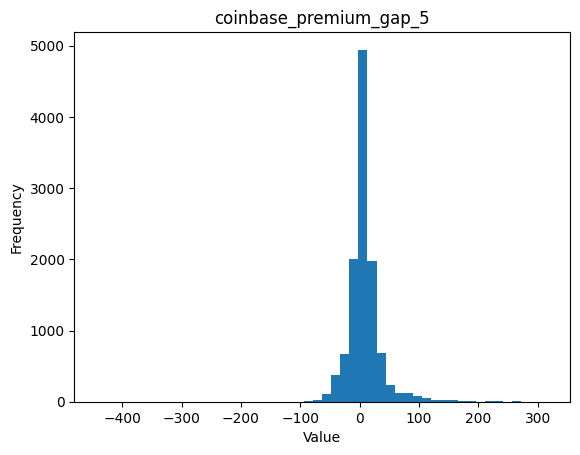

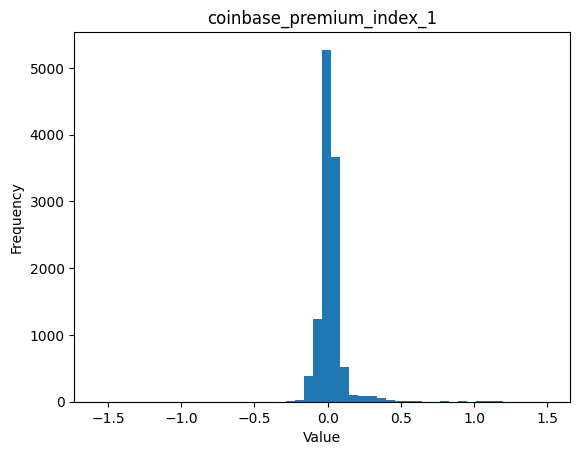

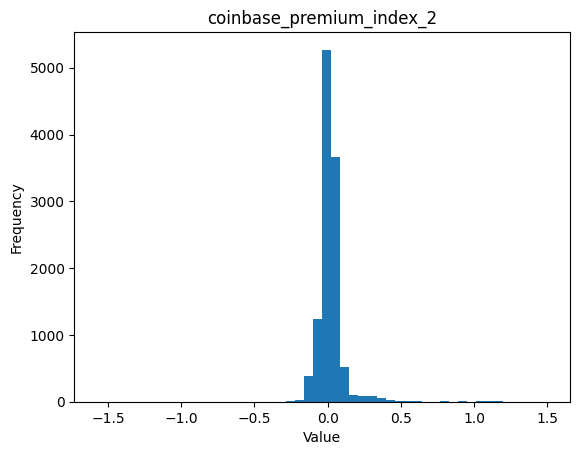

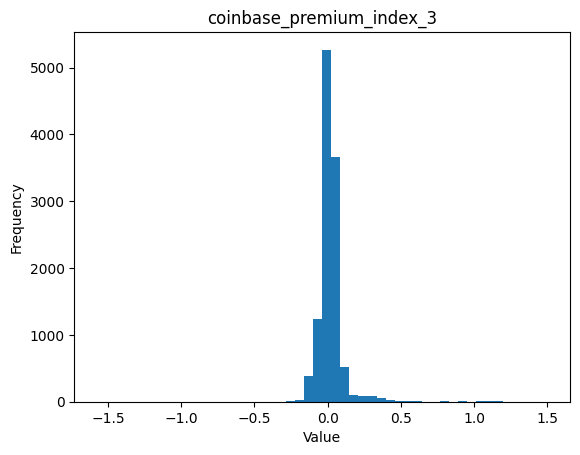

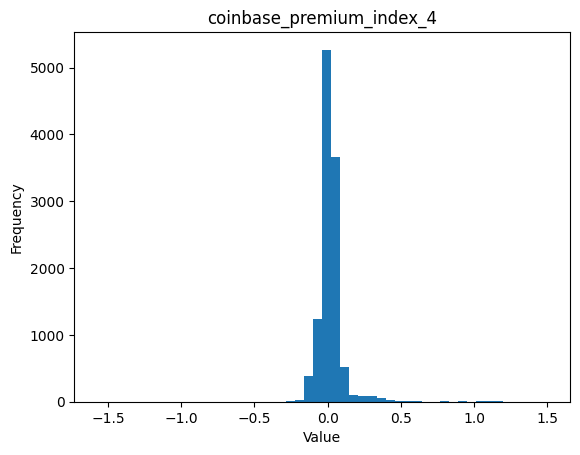

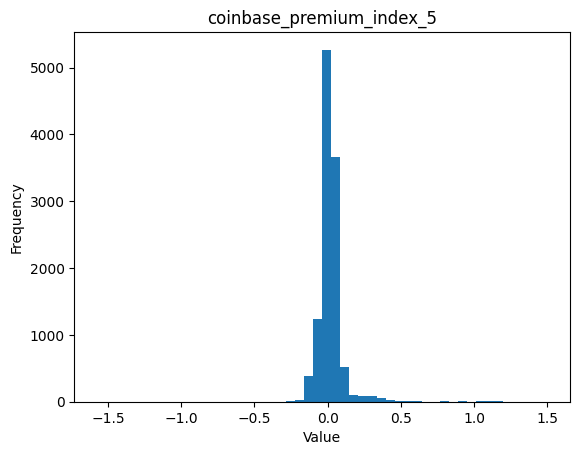

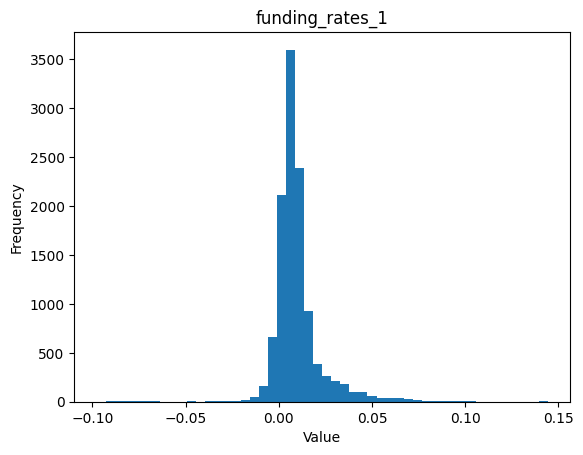

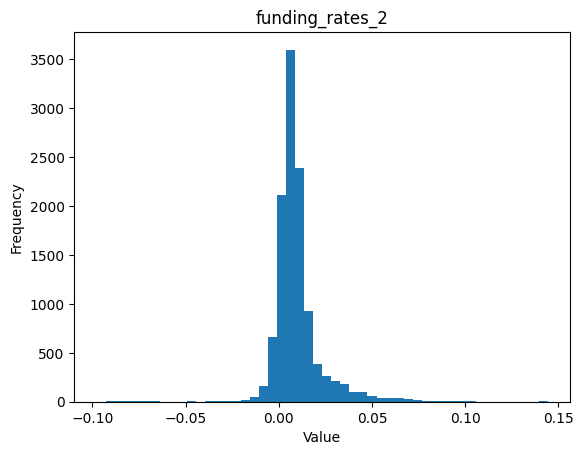

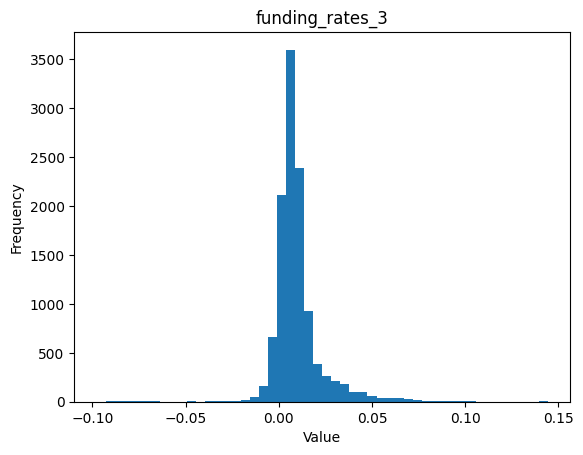

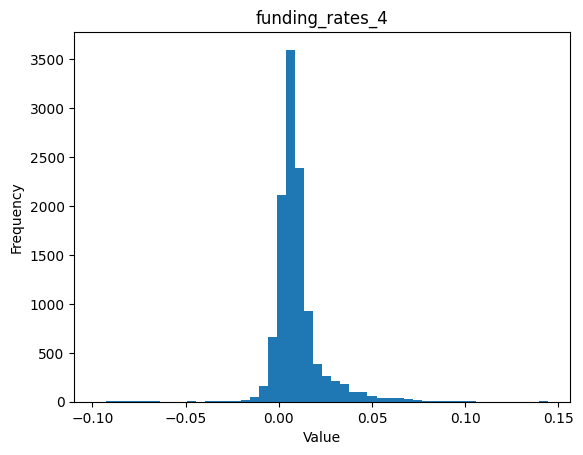

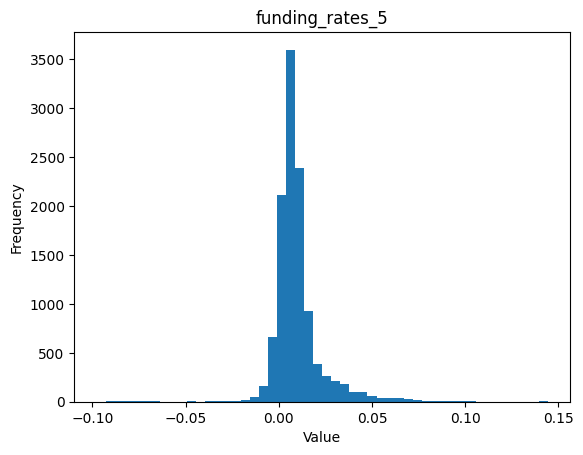

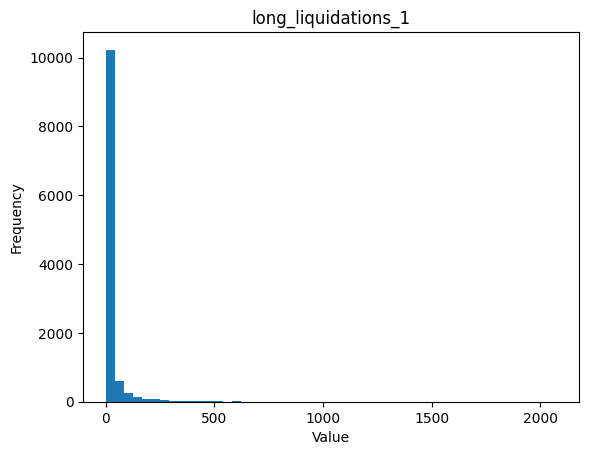

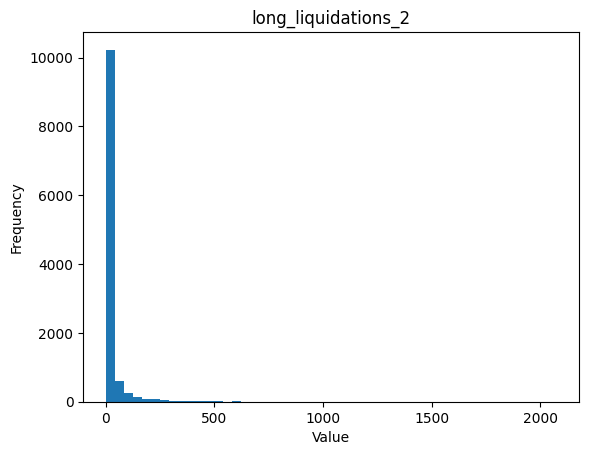

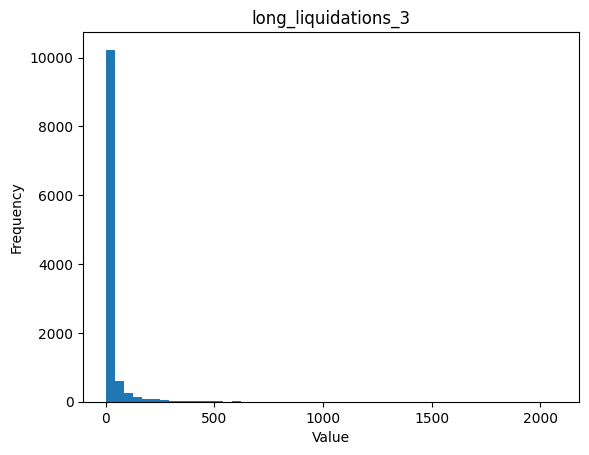

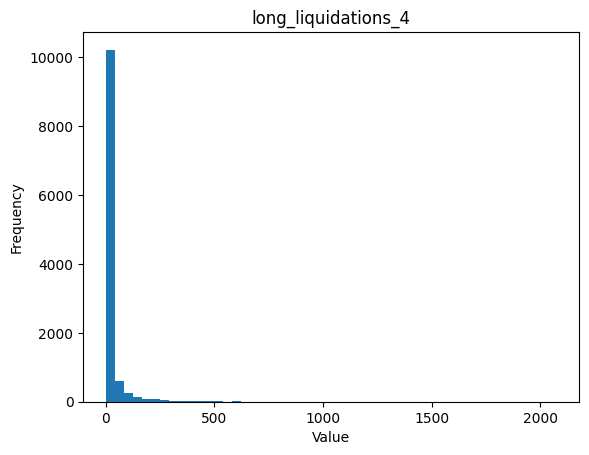

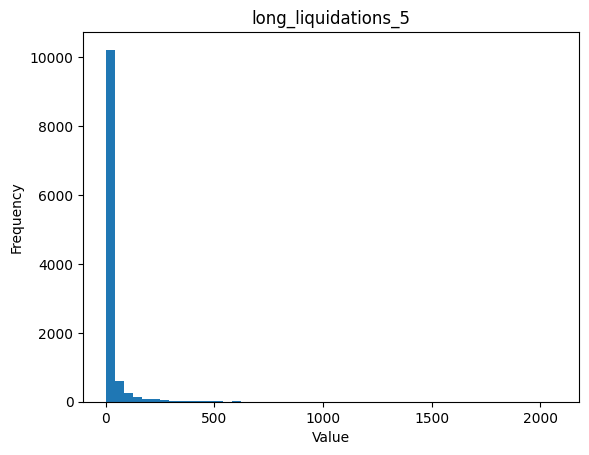

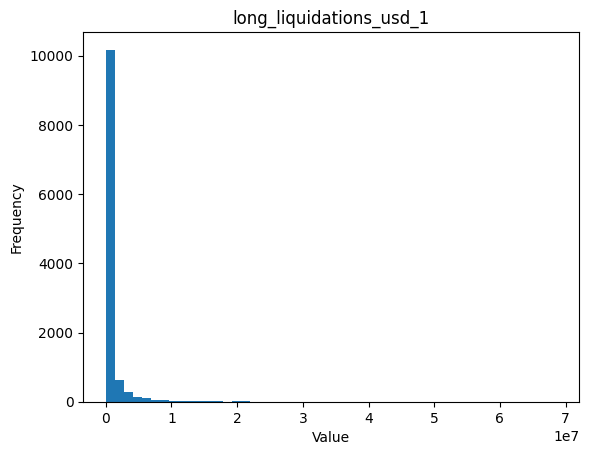

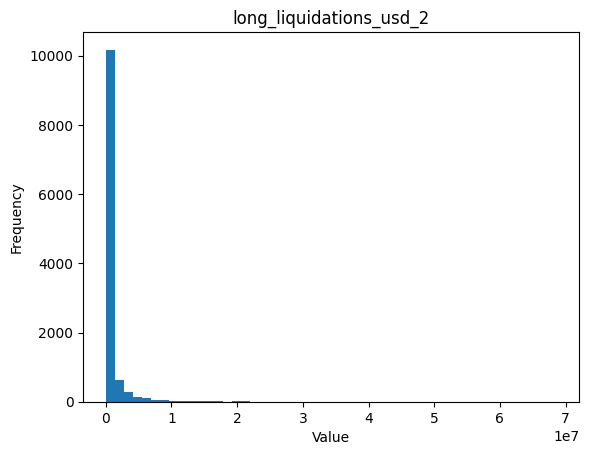

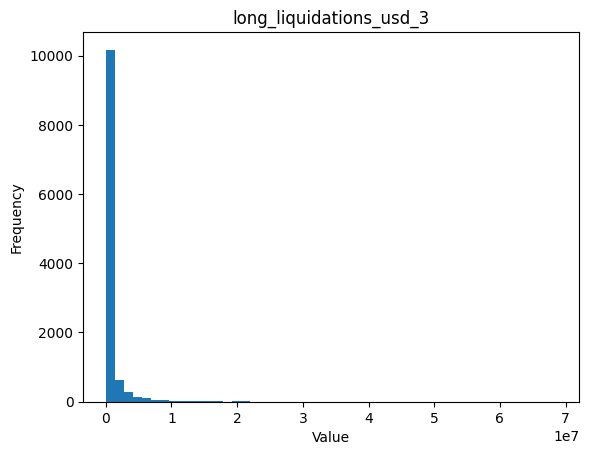

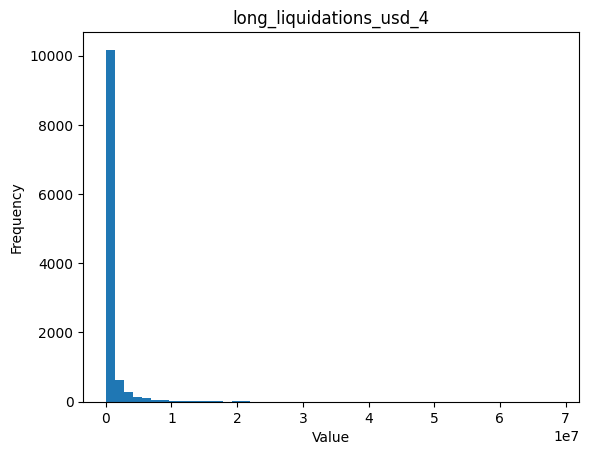

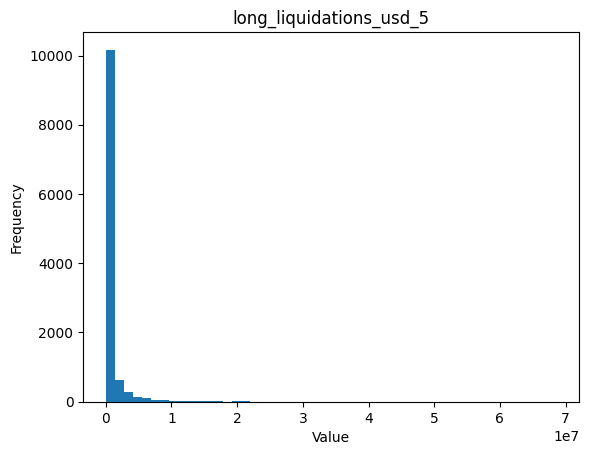

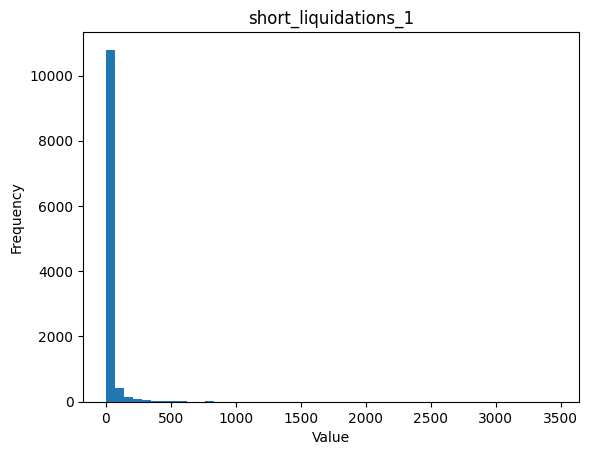

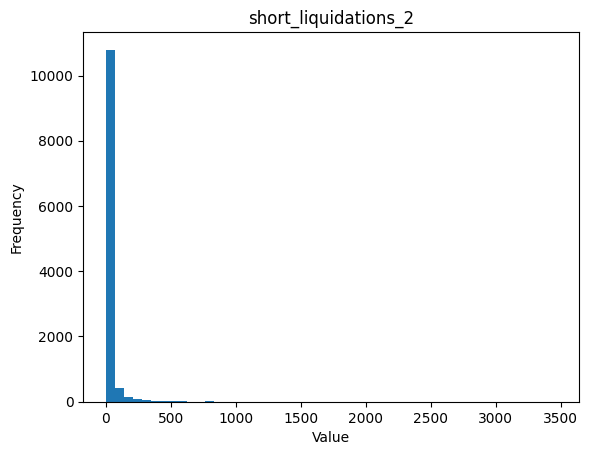

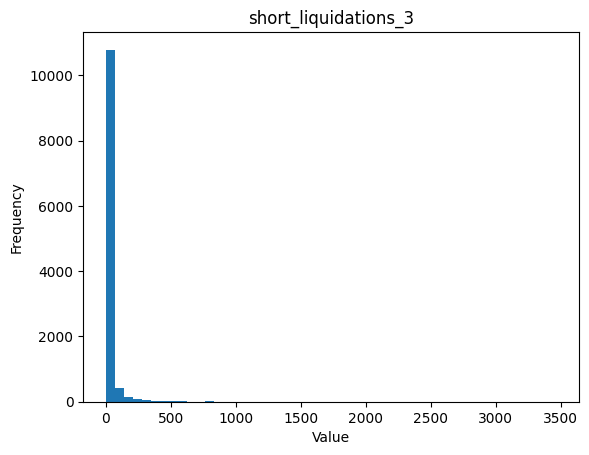

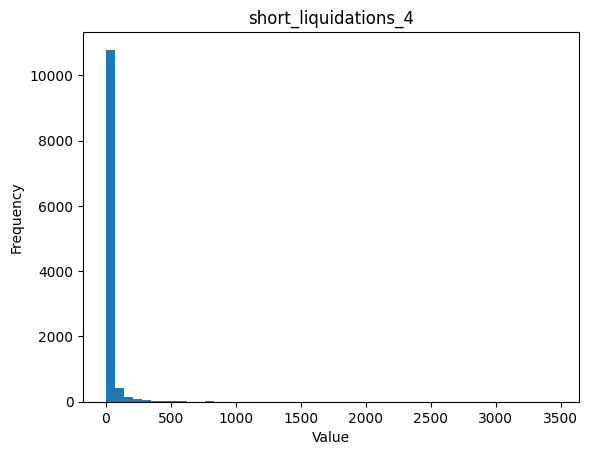

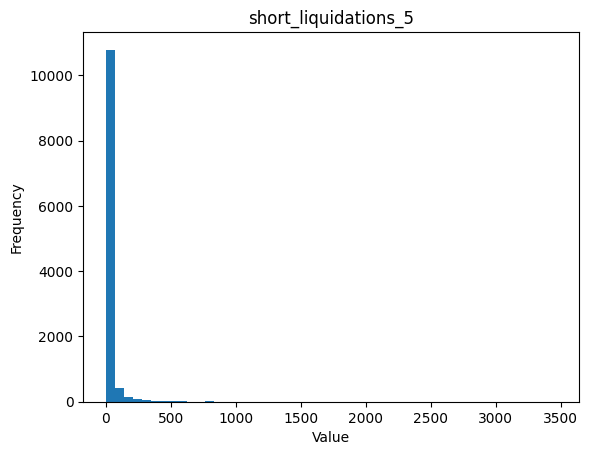

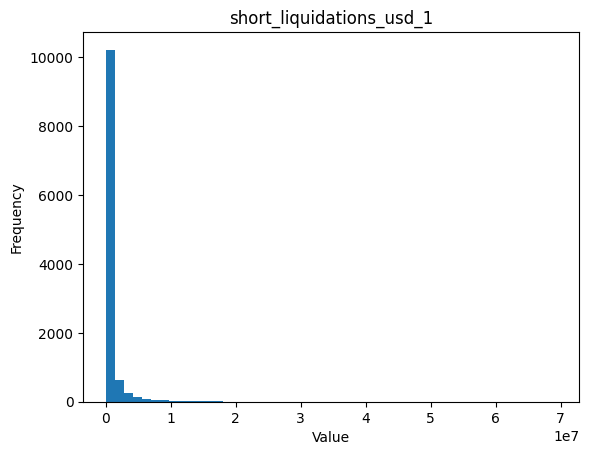

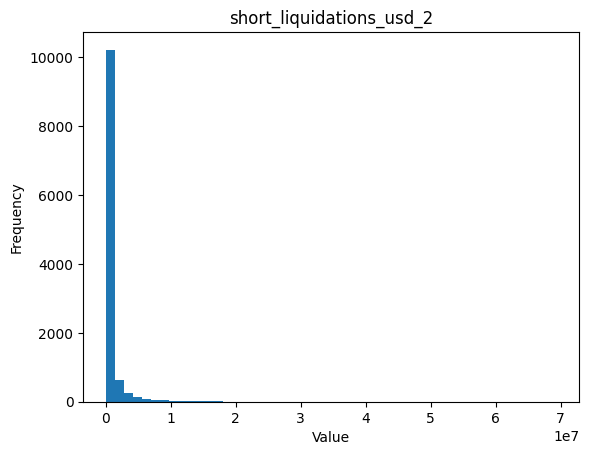

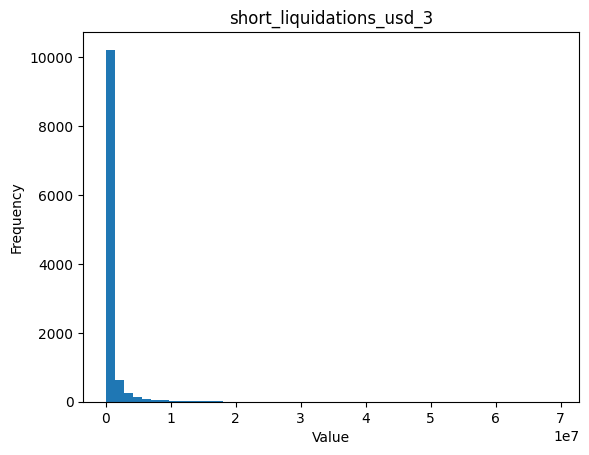

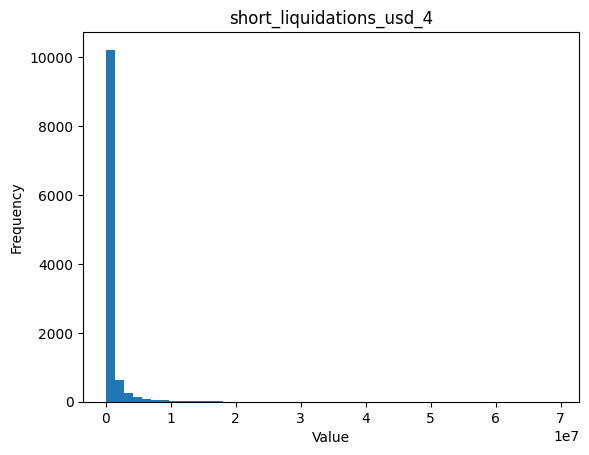

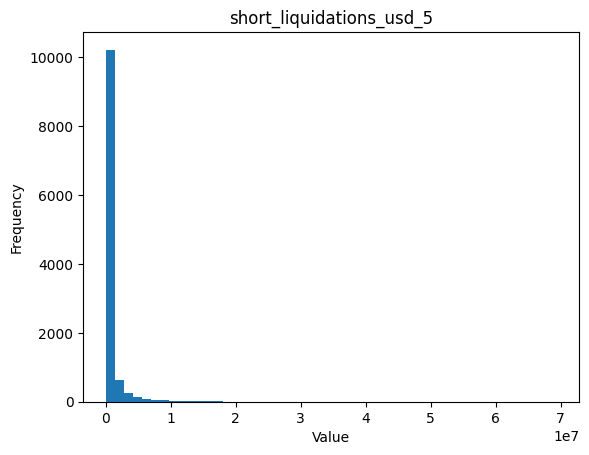

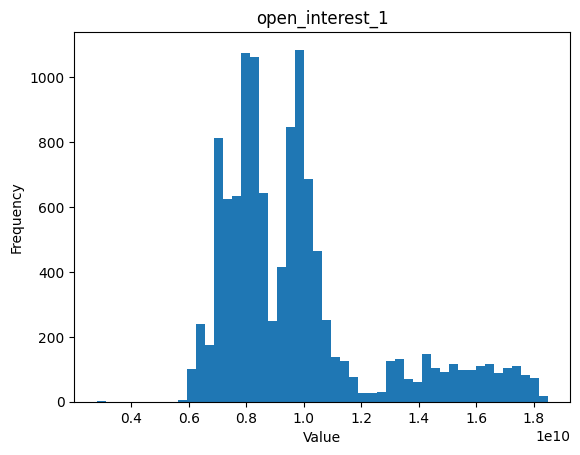

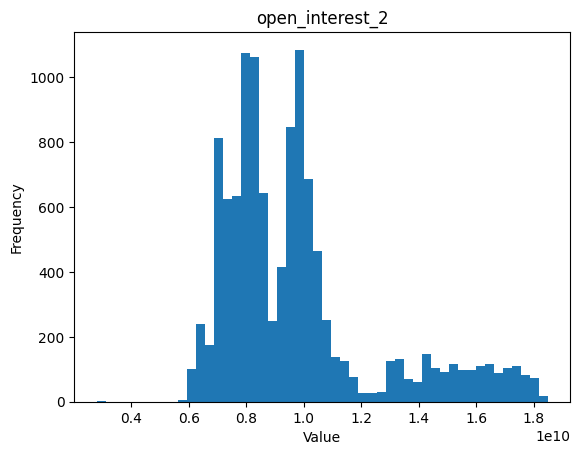

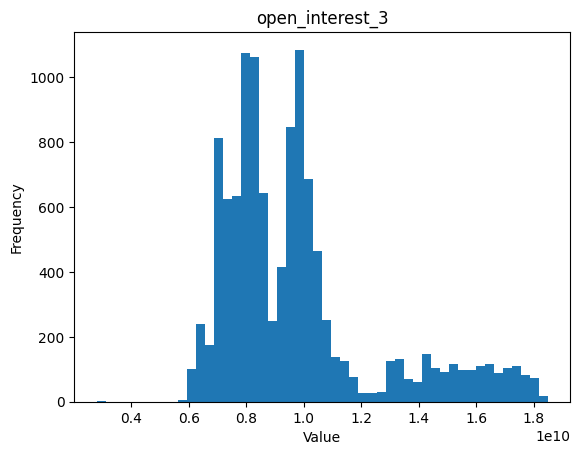

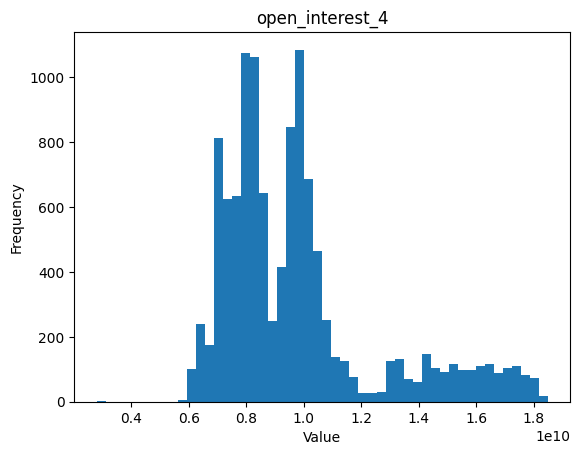

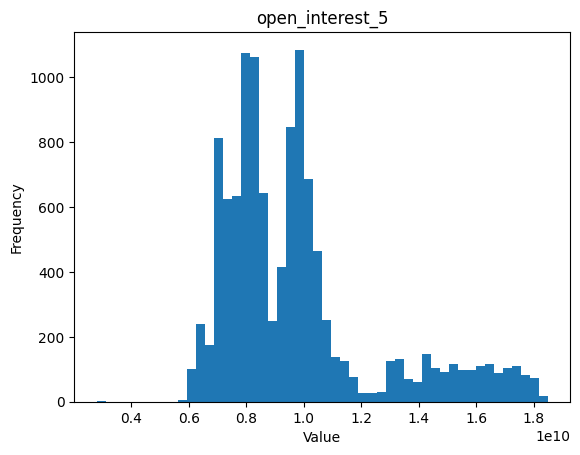

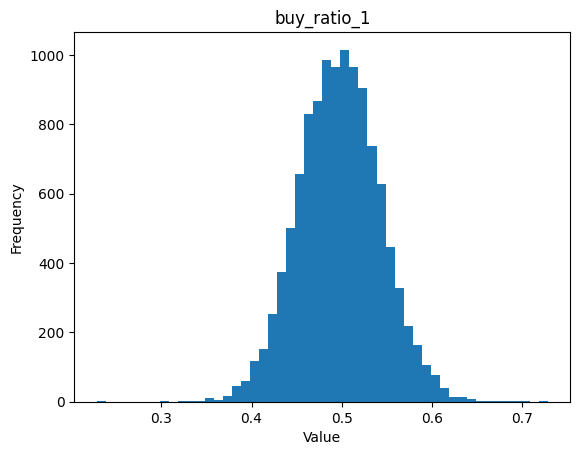

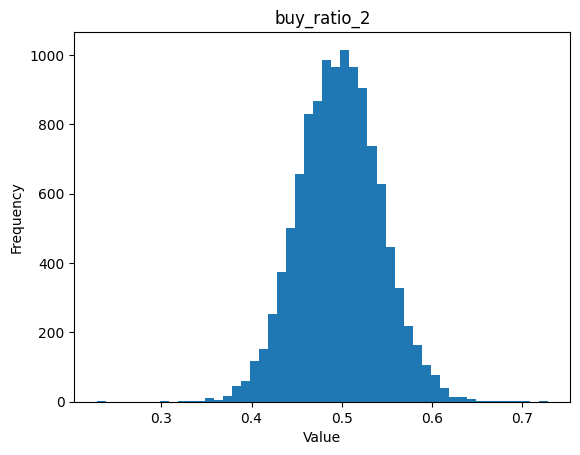

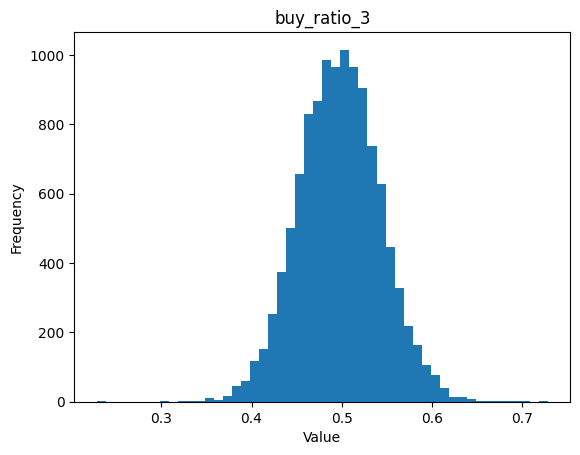

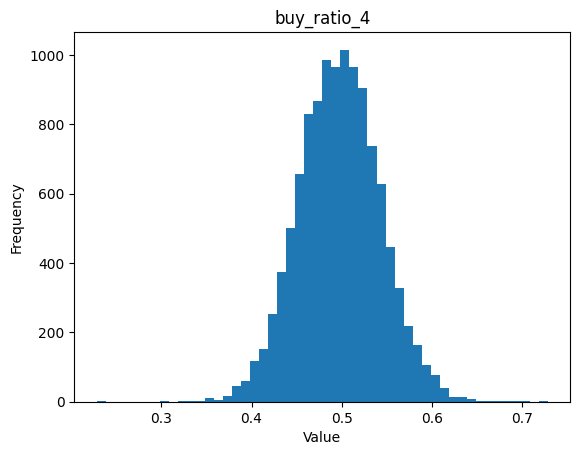

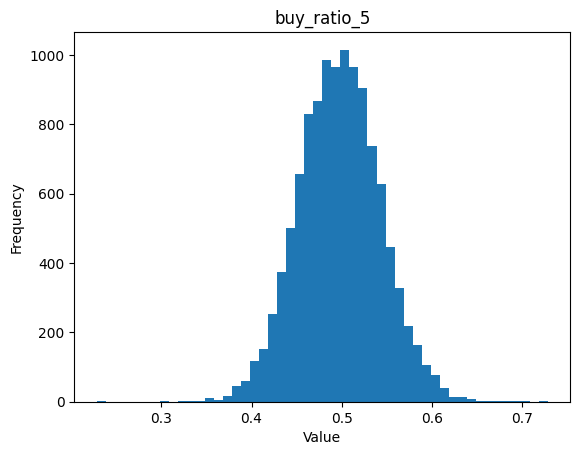

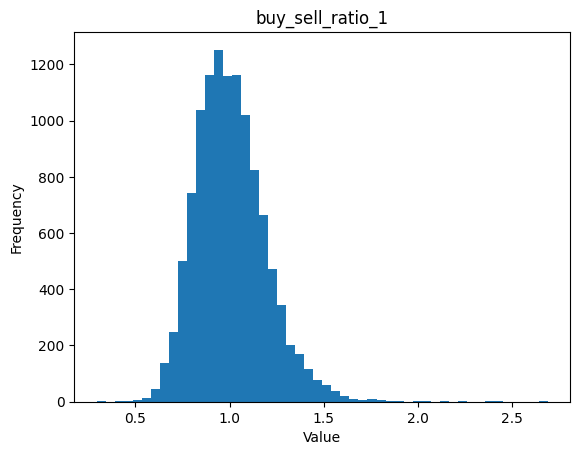

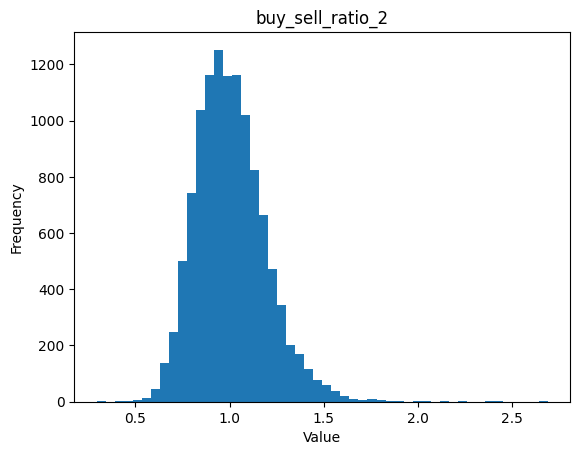

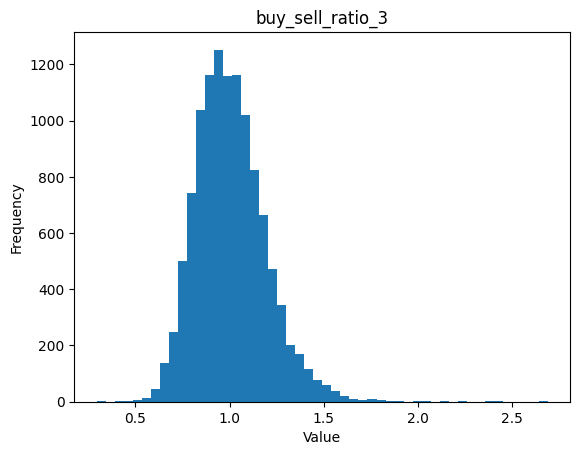

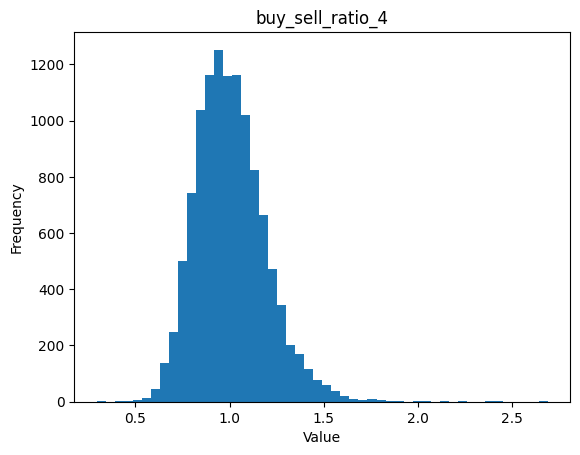

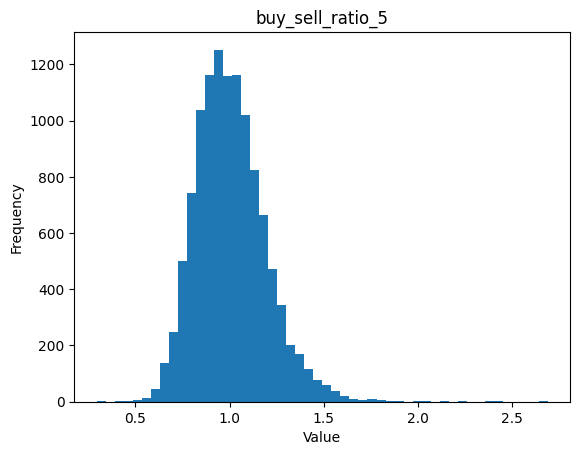

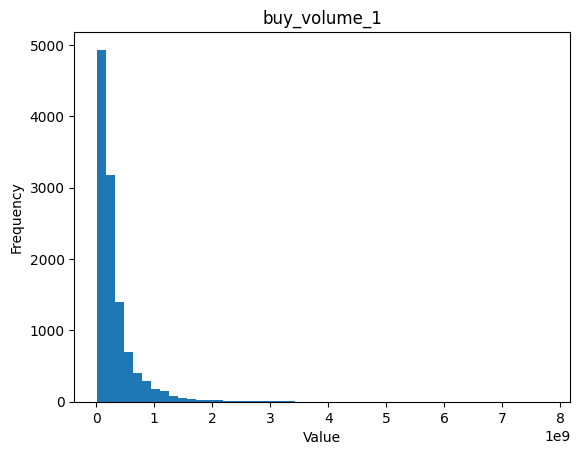

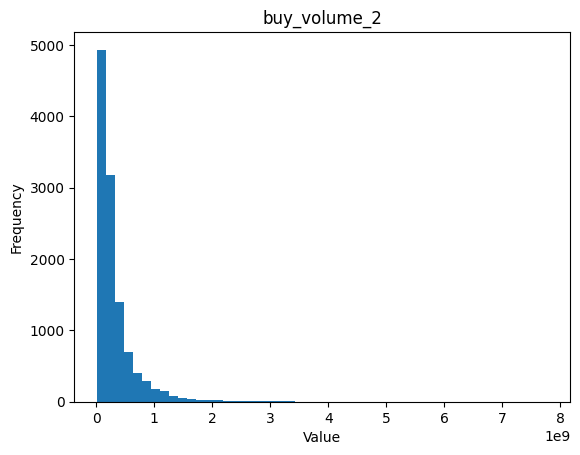

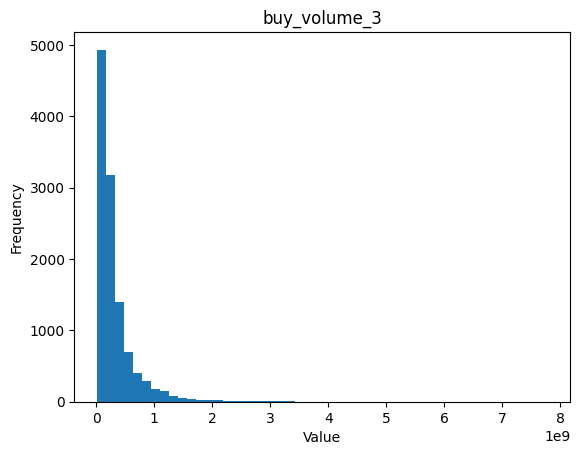

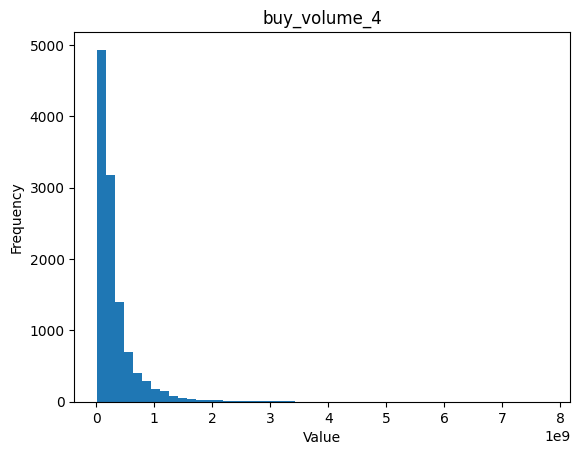

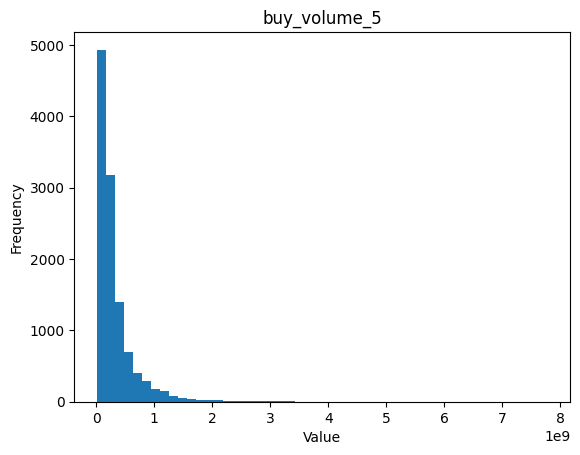

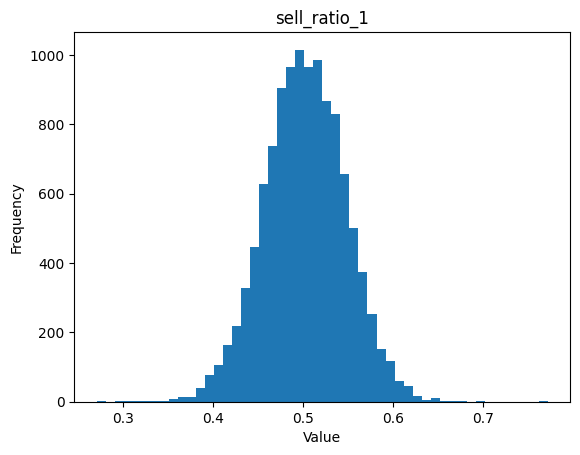

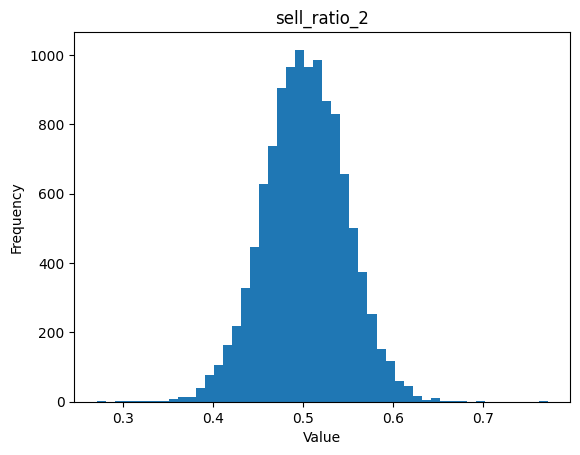

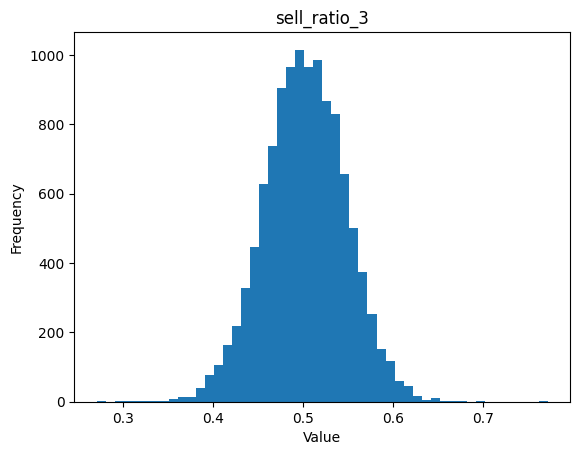

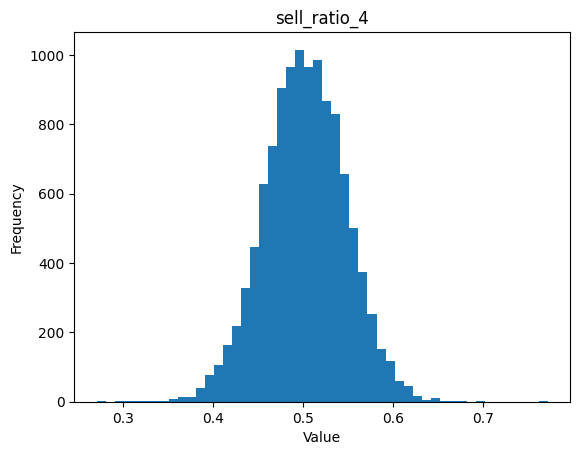

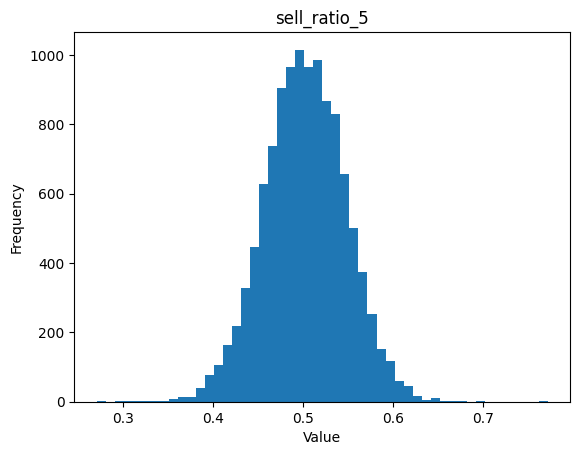

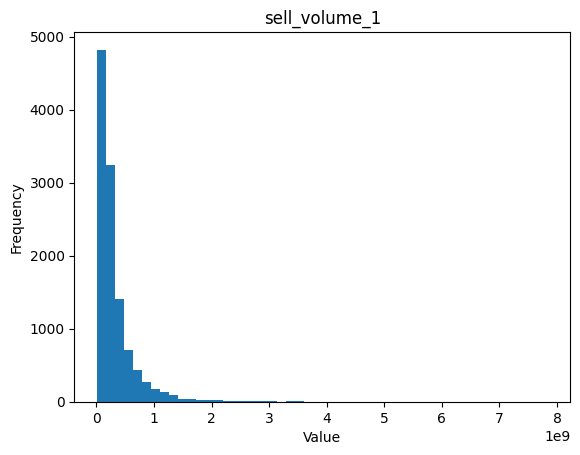

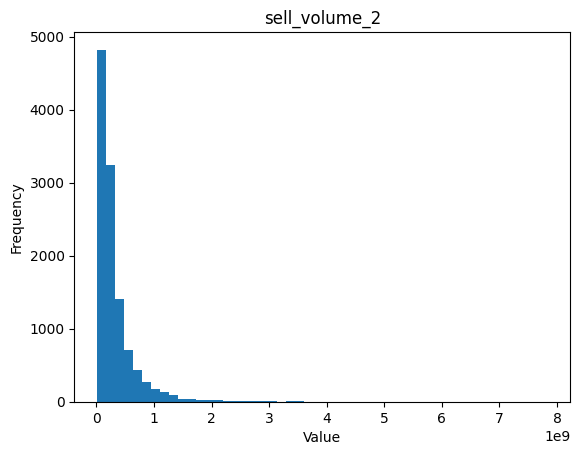

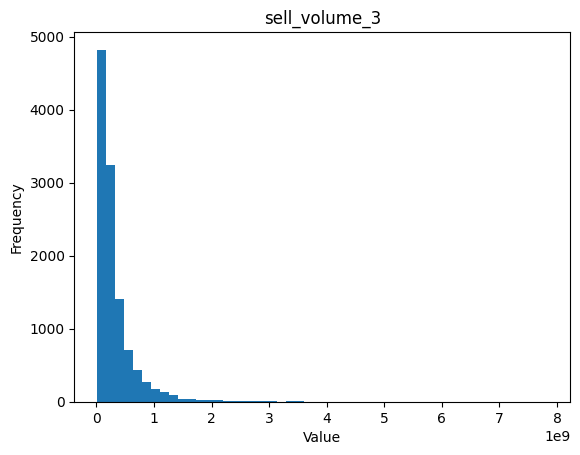

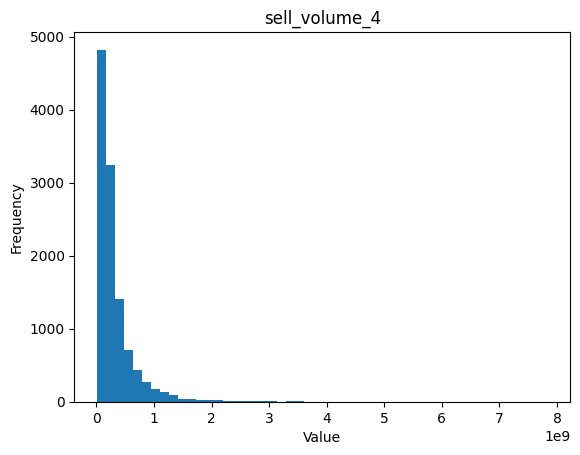

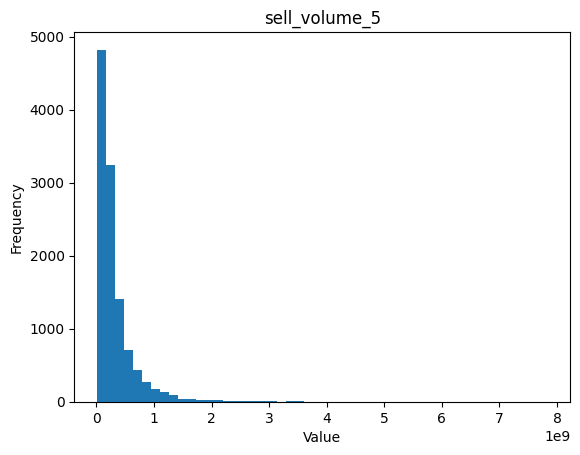

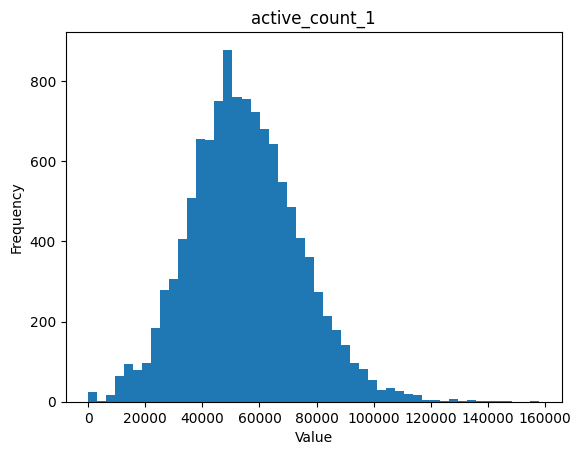

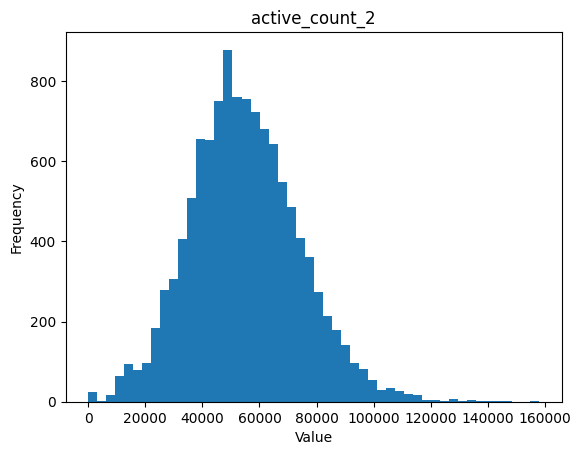

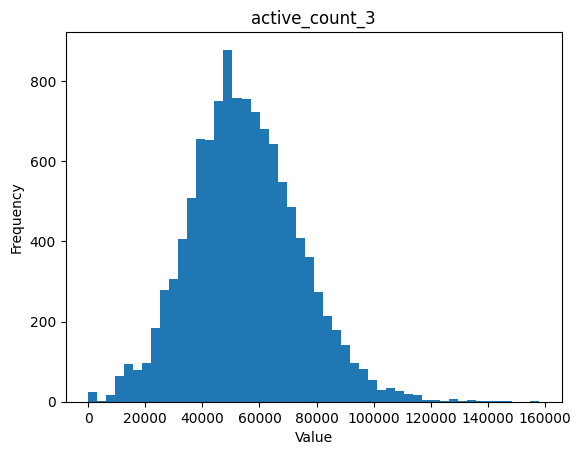

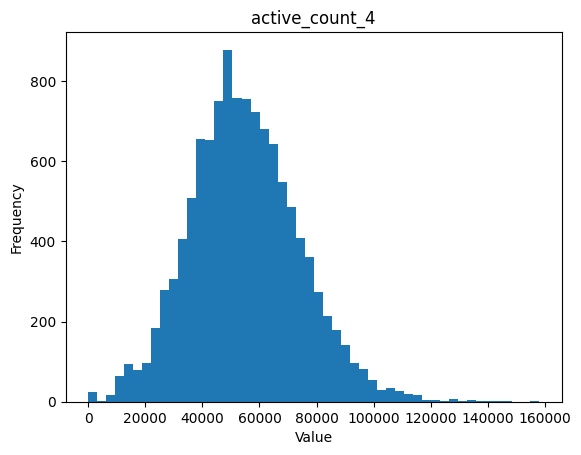

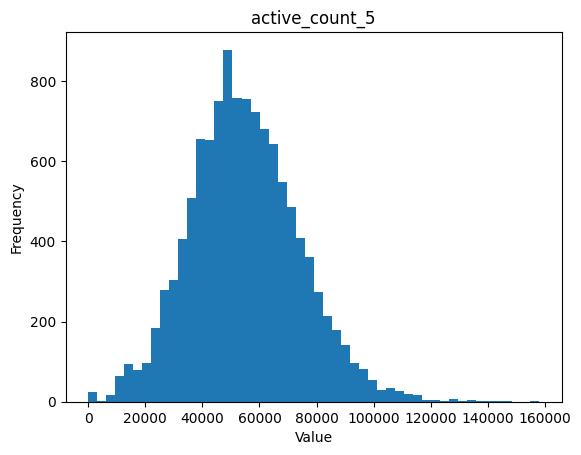

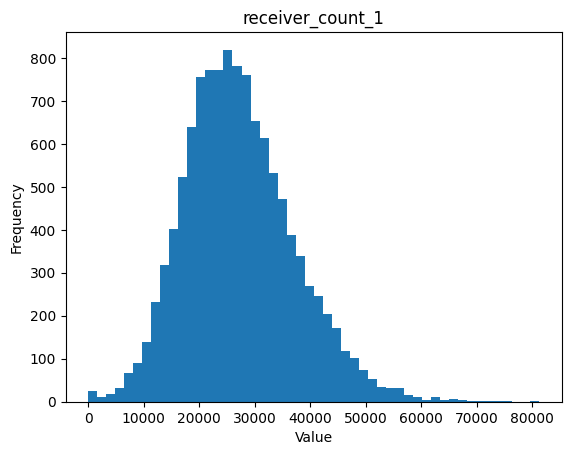

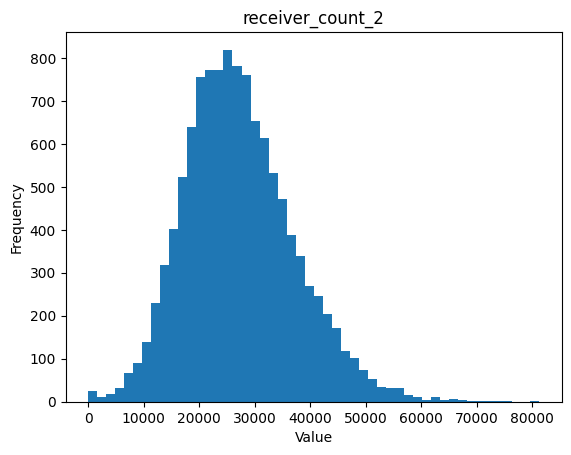

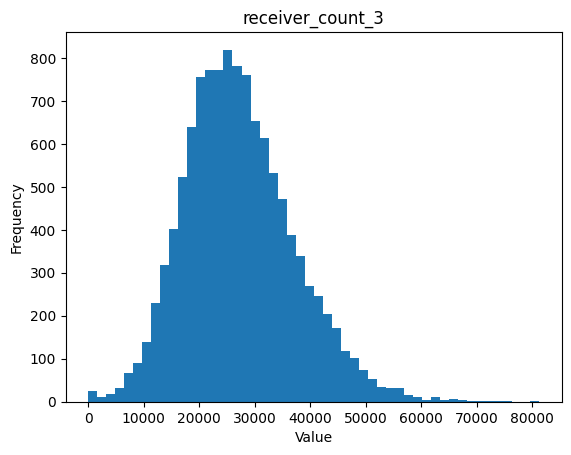

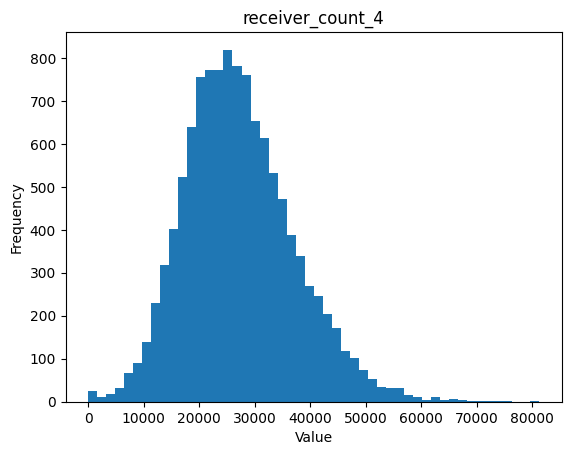

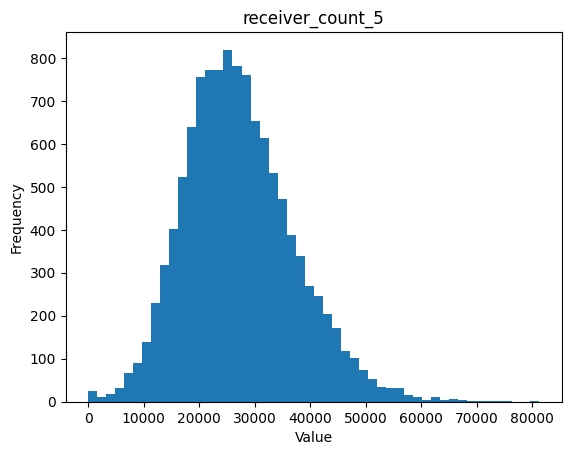

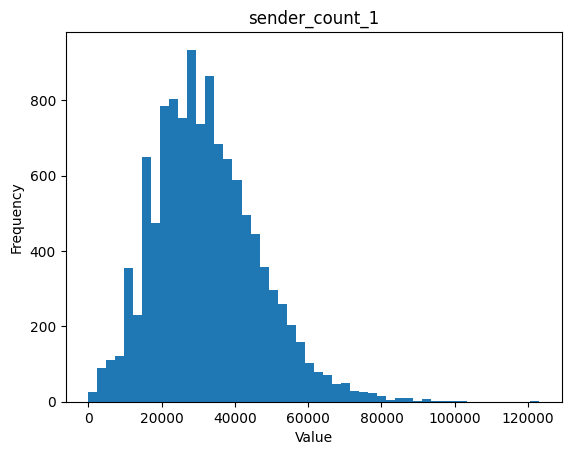

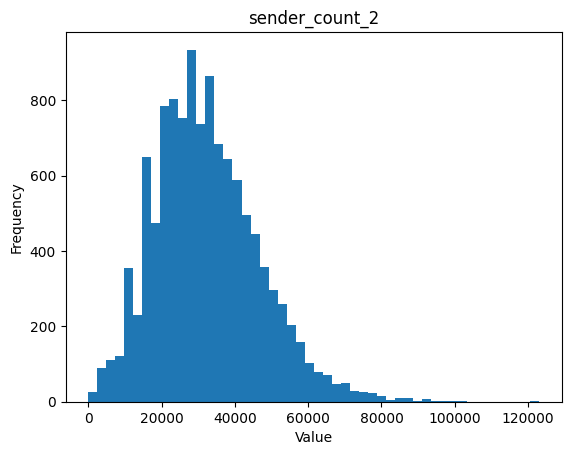

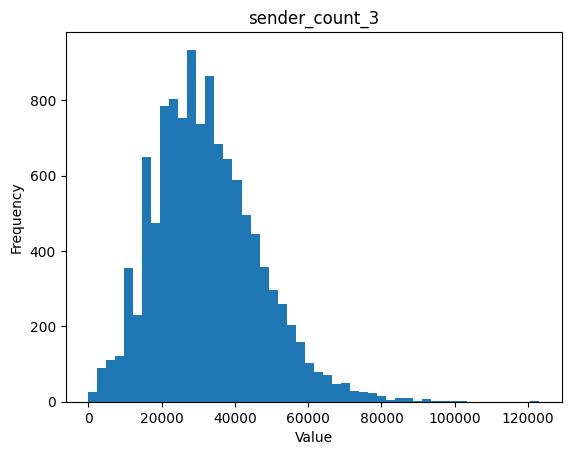

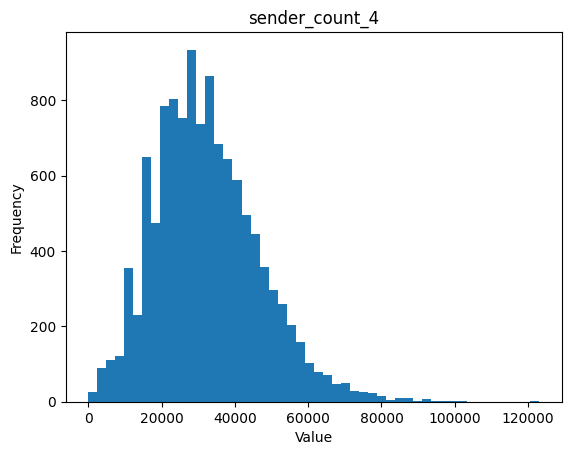

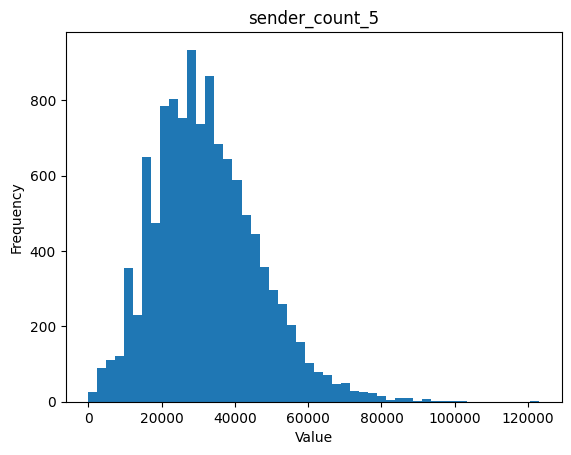

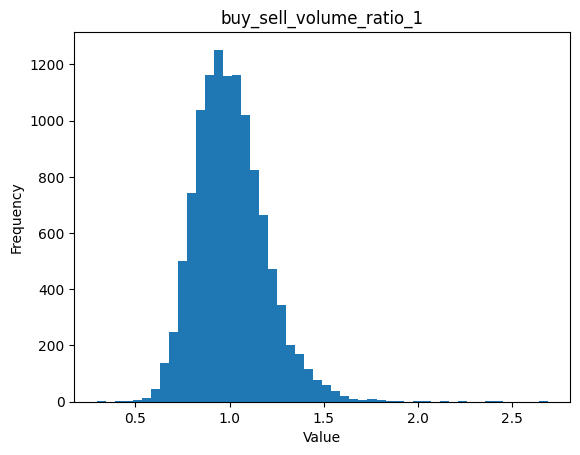

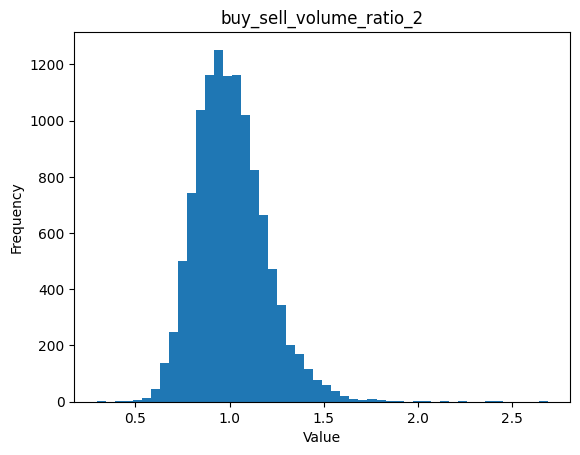

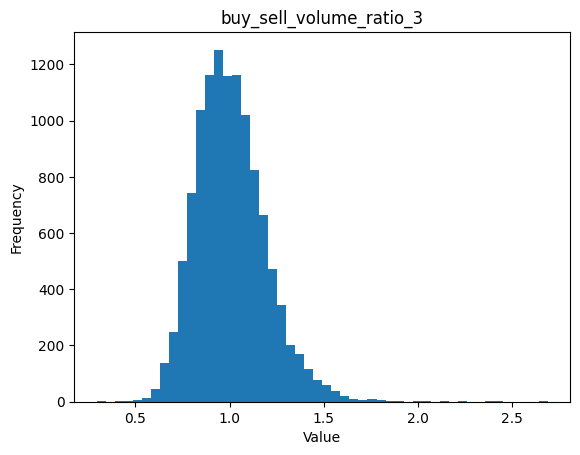

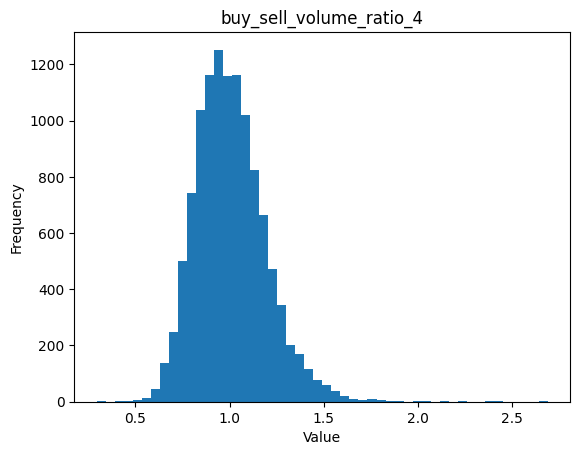

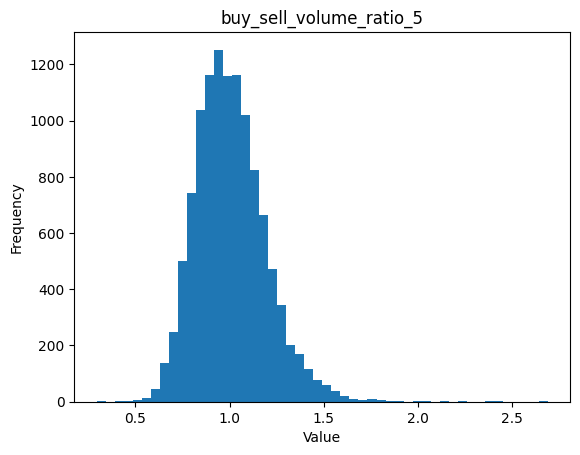

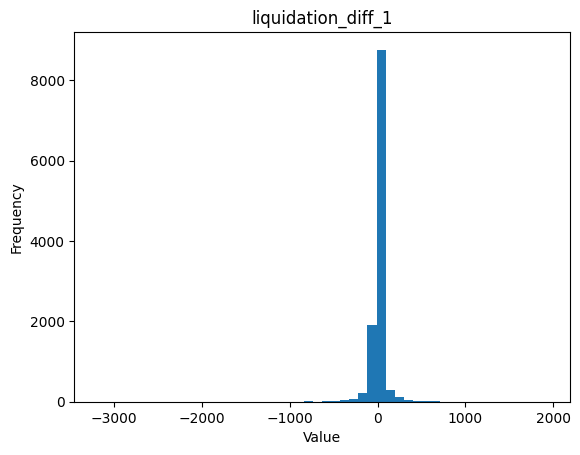

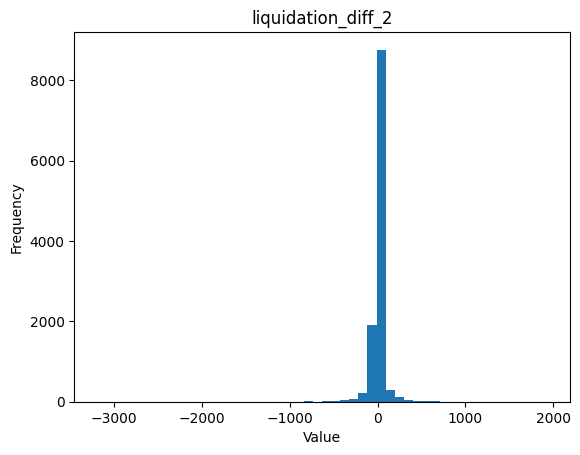

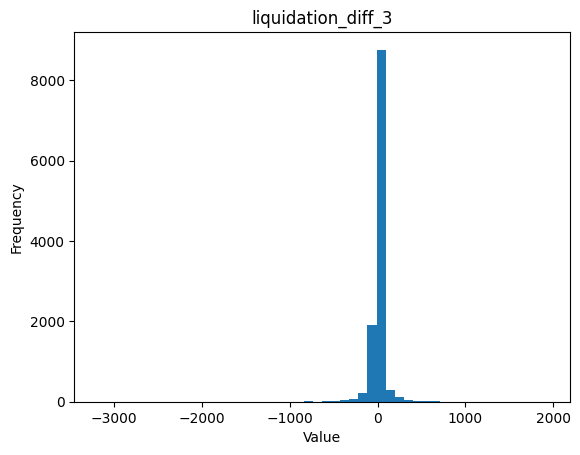

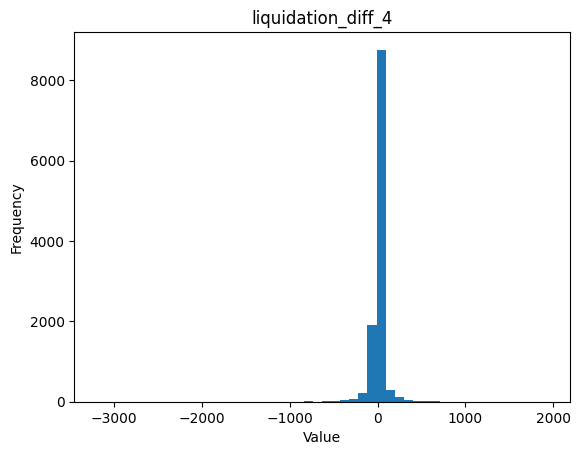

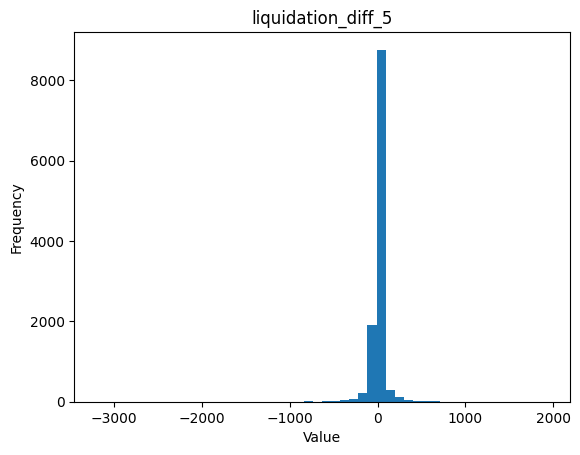

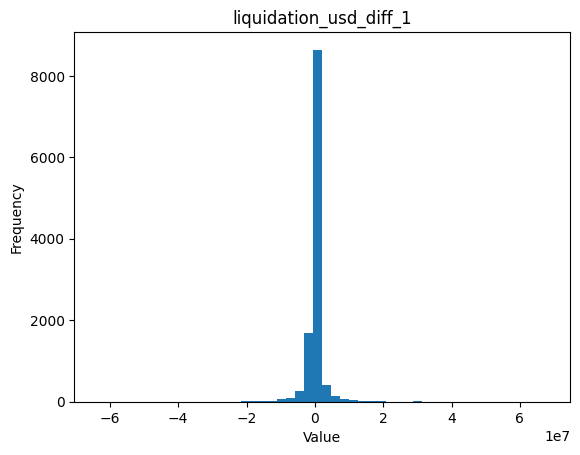

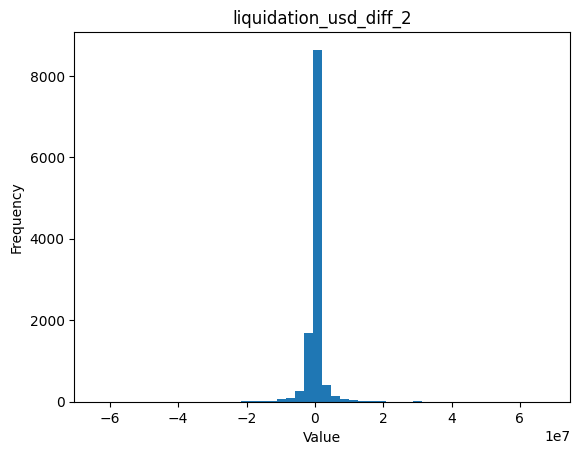

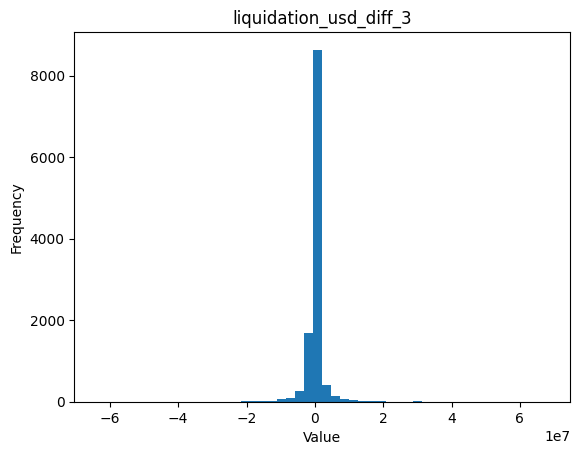

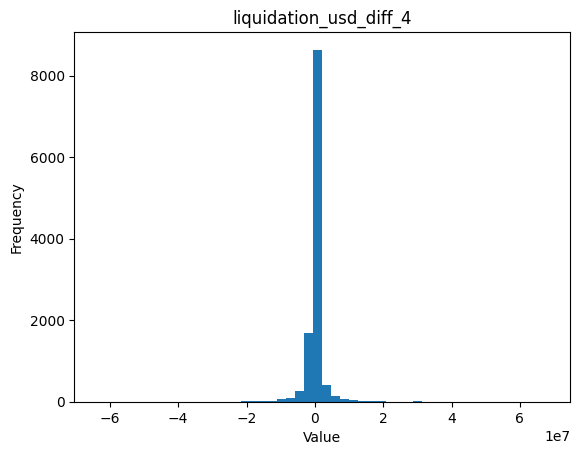

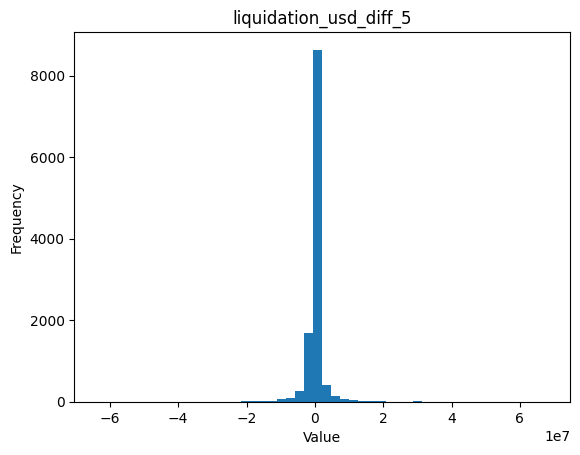

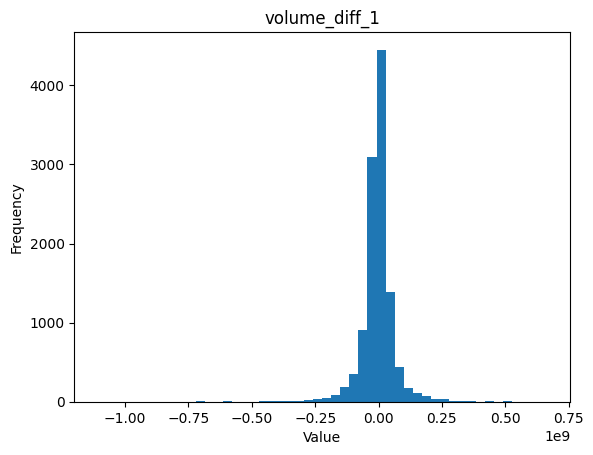

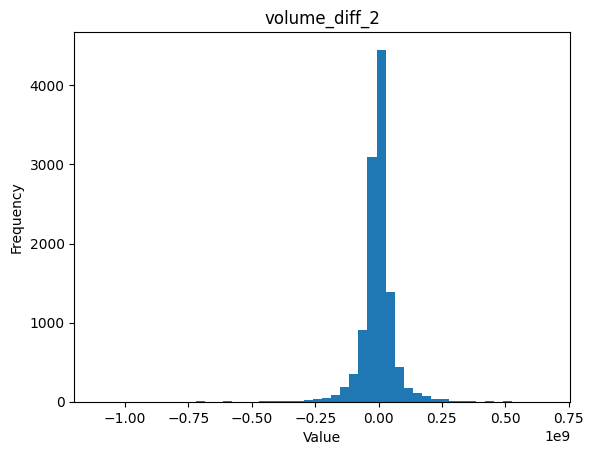

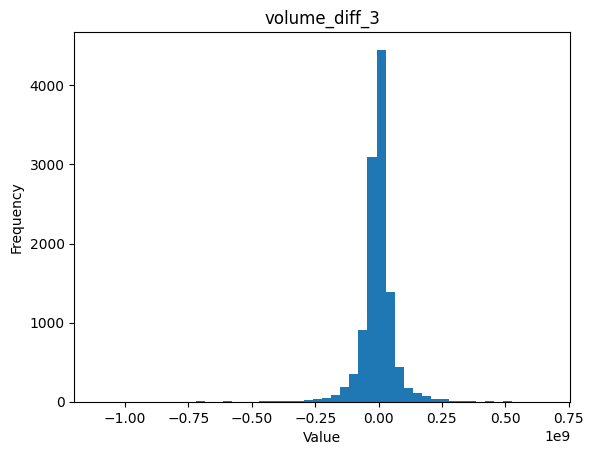

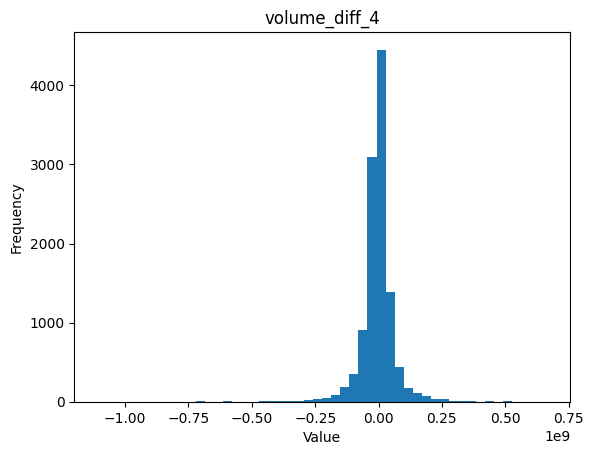

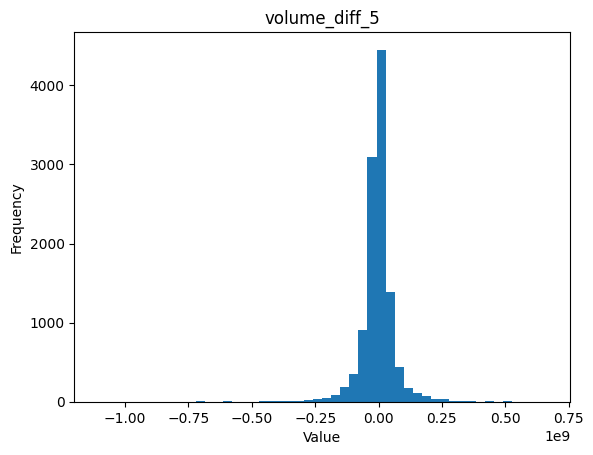

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in df_eda.columns:
  plt.hist(df_eda[col], bins=50)
  plt.title(col)
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.show()

In [ ]:
# 오른쪽으로 치우친 컬럼 리스트
right_skewed = [
    'coinbase_premium_gap',
    'liquidation_diff',
    'volume_diff',
    'coinbase_premium_gap_1',
    'coinbase_premium_gap_2',
    'coinbase_premium_gap_3',
    'coinbase_premium_gap_4',
    'coinbase_premium_gap_5',
    'liquidation_diff_1',
    'liquidation_diff_2',
    'liquidation_diff_3',
    'liquidation_diff_4',
    'liquidation_diff_5',
    'volume_diff_1',
    'volume_diff_2',
    'volume_diff_3',
    'volume_diff_4',
    'volume_diff_5'
]
# 왼쪽으로 치우친 컬럼 리스트
left_skewed = [
    'funding_rates',
    'long_liquidations',
    'long_liquidations_usd',
    'short_liquidations',
    'short_liquidations_usd',
    'open_interest',
    'buy_sell_ratio',
    'buy_volume',
    'sell_volume',
    'active_count',
    'receiver_count',
    'sender_count',
    'buy_sell_volume_ratio',
    'funding_rates_1',
    'funding_rates_2',
    'funding_rates_3',
    'funding_rates_4',
    'funding_rates_5',
    'long_liquidations_1',
    'long_liquidations_2',
    'long_liquidations_3',
    'long_liquidations_4',
    'long_liquidations_5',
    'long_liquidations_usd_1',
    'long_liquidations_usd_2',
    'long_liquidations_usd_3',
    'long_liquidations_usd_4',
    'long_liquidations_usd_5',
    'short_liquidations_1',
    'short_liquidations_2',
    'short_liquidations_3',
    'short_liquidations_4',
    'short_liquidations_5',
    'short_liquidations_usd_1',
    'short_liquidations_usd_2',
    'short_liquidations_usd_3',
    'short_liquidations_usd_4',
    'short_liquidations_usd_5',
    'open_interest_1',
    'open_interest_2',
    'open_interest_3',
    'open_interest_4',
    'open_interest_5',
    'buy_sell_ratio_1',
    'buy_sell_ratio_2',
    'buy_sell_ratio_3',
    'buy_sell_ratio_4',
    'buy_sell_ratio_5',
    'buy_volume_1',
    'buy_volume_2',
    'buy_volume_3',
    'buy_volume_4',
    'buy_volume_5',
    'sell_volume_1',
    'sell_volume_2',
    'sell_volume_3',
    'sell_volume_4',
    'sell_volume_5',
    'active_count_1',
    'active_count_2',
    'active_count_3',
    'active_count_4',
    'active_count_5',
    'receiver_count_1',
    'receiver_count_2',
    'receiver_count_3',
    'receiver_count_4',
    'receiver_count_5',
    'sender_count_1',
    'sender_count_2',
    'sender_count_3',
    'sender_count_4',
    'sender_count_5',
    'buy_sell_volume_ratio_1',
    'buy_sell_volume_ratio_2',
    'buy_sell_volume_ratio_3',
    'buy_sell_volume_ratio_4',
    'buy_sell_volume_ratio_5'
]


In [ ]:
# df[right_skewed] = np.log1p(df[right_skewed])

# 왼쪽으로 치우친 컬럼에 반전 후 로그 적용
# df[left_skewed] = -np.log1p(-df[left_skewed])


/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [ ]:
from sklearn.preprocessing import QuantileTransformer

quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)


df[right_skewed] = quantile_transformer.fit_transform(df[right_skewed])

df[left_skewed] = quantile_transformer.fit_transform(df[left_skewed])


In [ ]:
from sklearn.preprocessing import PowerTransformer

# Yeo-Johnson 변환
pt = PowerTransformer(method='yeo-johnson')


df[right_skewed] = pt.fit_transform(df_eda[right_skewed])

df[left_skewed] = pt.fit_transform(df_eda[left_skewed])




---



In [ ]:
# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

### Model Training

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

class_names = [f'Class {i}' for i in sorted(train_df['target'].unique())]
# 모델 평가 함수
def evaluate_model(y_test, y_pred, model_name):
    """
    주어진 모델의 성능을 평가하고 혼동 행렬과 분류 보고서를 출력합니다.

    Parameters:
    y_test (array-like): 테스트 데이터의 실제 레이블
    y_pred (array-like): 모델이 예측한 레이블
    model_name (str): 모델의 이름 또는 설명

    Returns:
    None
    """
    print(f"\n{model_name} 모델 평가")
    # 분류 보고서 출력
    print("\n분류 보고서:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # 혼동 행렬 출력
    print("혼동 행렬:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


acc: 0.4355022831050228, auroc: 0.6238550913031754

lgb_model 모델 평가

분류 보고서:
              precision    recall  f1-score   support

   Class 0.0       0.00      0.00      0.00       149
   Class 1.0       0.42      0.51      0.46       678
   Class 2.0       0.46      0.56      0.50       745
   Class 3.0       0.20      0.01      0.02       180

    accuracy                           0.44      1752
   macro avg       0.27      0.27      0.25      1752
weighted avg       0.38      0.44      0.39      1752

혼동 행렬:


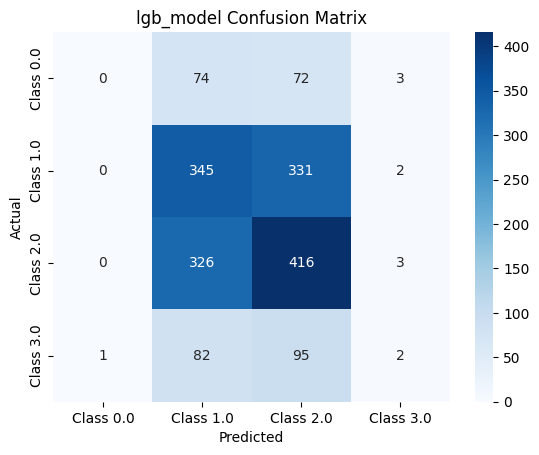

In [ ]:
# train_test_split 으로 valid set, train set 분리
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.drop(["target", "ID"], axis = 1),
    train_df["target"].astype(int),
    test_size=0.2,
    random_state=42,
)

# lgb dataset
train_data = lgb.Dataset(x_train, label=y_train)
valid_data = lgb.Dataset(x_valid, label=y_valid, reference=train_data)

# lgb params
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "num_leaves": 50,
    "learning_rate": 0.05,
    "n_estimators": 30,
    "random_state": 42,
    "verbose": 0,
}

# lgb train
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=valid_data,
)

# lgb predict
y_valid_pred = lgb_model.predict(x_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred_class)
auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")

print(f"acc: {accuracy}, auroc: {auroc}")

# 추가된 confusion matrix 구현 부분
evaluate_model(y_valid, y_valid_pred_class, "lgb_model")

In [ ]:
# performance 체크후 전체 학습 데이터로 다시 재학습
x_train = train_df.drop(["target", "ID"], axis = 1)
y_train = train_df["target"].astype(int)
train_data = lgb.Dataset(x_train, label=y_train)
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



### Inference

In [ ]:
# lgb predict
y_test_pred = lgb_model.predict(test_df.drop(["target", "ID"], axis = 1))
y_test_pred_class = np.argmax(y_test_pred, axis = 1)

### Output File Save

In [ ]:
# output file 할당후 save
submission_df = submission_df.assign(target = y_test_pred_class)
submission_df.to_csv("output.csv", index=False)